# Imports

In [1]:
import pandas as pd
pd.set_option('display.float_format', '{:.10f}'.format)
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import seaborn as sns
rng = np.random.default_rng(seed=17)
from statsmodels.tsa.stattools import pacf, acf, adfuller
from statsmodels.stats.stattools import jarque_bera
from scipy.ndimage import shift
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

results = pd.DataFrame(columns=['S', 'R^2', 'IKA', 'DW', 'MSE'])

results_2 = pd.DataFrame(columns=['S', 'R^2', 'IKA', 'DW', 'MSE'])


non_df = pd.read_csv('NONREVNS.txt', names=['NONREVNS'], header=None)
Revolns = pd.read_csv('Revolns.txt', names=['Revolns'], header=None)

sns.set(rc={'figure.figsize':(14, 8)})

In [2]:
alpha = 0.05

print(f"alpha = {alpha}\n")
# ADF Test
print("==== Augmented Dickey–Fuller for NONREVNS: ")
result = adfuller(non_df, autolag='AIC')
print(f'ADF Statistic: {result[0]:.4g}')
print(f'p-value: {result[1]:.4g}')
if result[1] < alpha:
    print("The process is stationary.")
else:
    print("The process is non-stationary.") 
    

print("\n==== Augmented Dickey–Fuller for Revolns: ")
result = adfuller(Revolns, autolag='AIC')
print(f'ADF Statistic: {result[0]:.4g}')
print(f'p-value: {result[1]:.4g}')
if result[1] < alpha:
    print("The process is stationary.")
else:
    print("The process is non-stationary.")

alpha = 0.05

==== Augmented Dickey–Fuller for NONREVNS: 
ADF Statistic: 2.477
p-value: 0.999
The process is non-stationary.

==== Augmented Dickey–Fuller for Revolns: 
ADF Statistic: 1.873
p-value: 0.9985
The process is non-stationary.


In [3]:
class MLS:
    def __init__(self):
        self.coefs = []
    
    def fit(self, X, y):
        self.coefs.append(np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y))
        
    def predict(self, X):
        return np.dot(X, self.weights()).flatten()

    def weights(self):
        return np.array(self.coefs[-1])


In [4]:
class RLS:
    def __init__(self, n_features, forgetting_factor=1.0, delta=1.0):
        self.forgetting_factor = forgetting_factor # how much weight we give to older data compared to newer data
        self.delta = delta # regularization
        self.weights = np.random.rand(n_features, 1)
        self.covariance_matrix = (1 / delta) * np.eye(n_features)
        self.coefs = []
    
    def fit(self, X, y):
        for i in range(X.shape[0]):
            xi = X[i].reshape(-1, 1)
            yi = y[i]
            prediction = np.dot(xi.T, self.weights)
            error = yi - prediction
            gain = np.dot(self.covariance_matrix, xi) / (self.forgetting_factor + np.dot(np.dot(xi.T, self.covariance_matrix), xi))
            self.weights = self.weights + gain * error
            self.coefs.append(self.weights)
            self.covariance_matrix = (1 / self.forgetting_factor) * (self.covariance_matrix - np.dot(np.dot(gain, xi.T), self.covariance_matrix))
        
    def predict(self, X):
        return np.dot(X, self.weights).flatten()


In [5]:
def dynamic_predict_rls(rls_model, X_test):
    predictions = []
    for xi in X_test:
        xi = xi.reshape(1, -1)
        prediction = rls_model.predict(xi)
        predictions.append(prediction[0])
        rls_model.fit(xi, prediction)
    return predictions

In [6]:
def calculate_sma(data, window):
    return np.pad(np.convolve(data, np.ones(window) / window, mode='valid'), (window-1, 0), mode='constant')

In [7]:
def calculate_ema(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    
    return np.pad(out[window-1:], (window-1, 0), mode='constant')

In [8]:
def DW(res):
    return np.sum(np.diff(res, axis=0)*np.diff(res, axis=0)) / np.sum(res*res)

def metric_S(y_true, y_pred):
    return np.power((y_true-y_pred), 2).sum()

def metric_R_sq(y_true, y_pred):
    return np.var(y_pred)/np.var(y_true)

def metric_IKA(y_true, y_pred, params):
    return len(y_true)*np.log(np.power((y_true-y_pred), 2).sum()) + 2*(params[0]+params[1]+1)

def metric_MSE(y_true, y_pred):
    return (np.power((y_true-y_pred), 2).sum())/len(y_true)

def metric_RMSE(y_true, y_pred):
    return np.sqrt((np.power((y_true-y_pred), 2).sum())/len(y_true))

def metric_theil_a(incomes):
    n = len(incomes)
    total_income = np.sum(incomes)
    mean_income = total_income / n

    if mean_income == 0:
        return 0

    theil_sum = 0
    for income in incomes:
        if income > 0:
            p = income / total_income
            theil_sum += p * np.log(income / mean_income)

    theil_coefficient = theil_sum / n

    return theil_coefficient

import numpy as np

def metric_MAE(actual, predicted):
    return np.mean(np.abs(actual - predicted))


def metric_MAPE(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100


In [9]:
def add_results(df, y_true, y_pred):
    if isinstance(y_true, np.ndarray):
        return pd.concat([df, pd.DataFrame([{'S': metric_S(y_true, y_pred),
                                'R^2': metric_R_sq(y_true, y_pred),
                                'IKA': metric_IKA(y_true, y_pred, [1, 1]),
                                'DW': DW(y_true - y_pred),
                                'MSE': metric_MSE(y_true, y_pred),
                                'RMSE': metric_RMSE(y_true, y_pred),
                                'MAE': metric_MAE(y_true, y_pred),
                                'MAPE': metric_MAPE(y_true, y_pred),
                                'Theil-a': metric_theil_a(y_pred)}])], axis=0, ignore_index=True)
    else:
        return pd.concat([df, pd.DataFrame([{'S': metric_S(y_true.values.flatten(), y_pred),
                                'R^2': metric_R_sq(y_true.values.flatten(), y_pred),
                                'IKA': metric_IKA(y_true.values.flatten(), y_pred, [1, 1]),
                                'DW': DW(y_true.values.flatten() - y_pred),
                                'MSE': metric_MSE(y_true.values.flatten(), y_pred),
                                'RMSE': metric_RMSE(y_true.values.flatten(), y_pred),
                                'MAE': metric_MAE(y_true.values.flatten(), y_pred),
                                'MAPE': metric_MAPE(y_true.values.flatten(), y_pred),
                                'Theil-a': metric_theil_a(y_pred)}])], axis=0, ignore_index=True)

# NONREVNS

In [10]:
non_df.describe()

,NONREVNS
count,787.0000000000
mean,386.5194409149
std,433.7709732594
min,5.2000000000
25%,51.4000000000
50%,188.2000000000
75%,563.4000000000
max,1609.0000000000


Як ми бачимо значення нашого датасету не дуже великі, тому логарифмування, або інші трансформації для зменшення діапазон значень не потрібні

[Text(0.5, 1.0, 'NONREVNS'),
 Text(0.5, 0, 'time'),
 Text(0, 0.5, 'number of credits')]

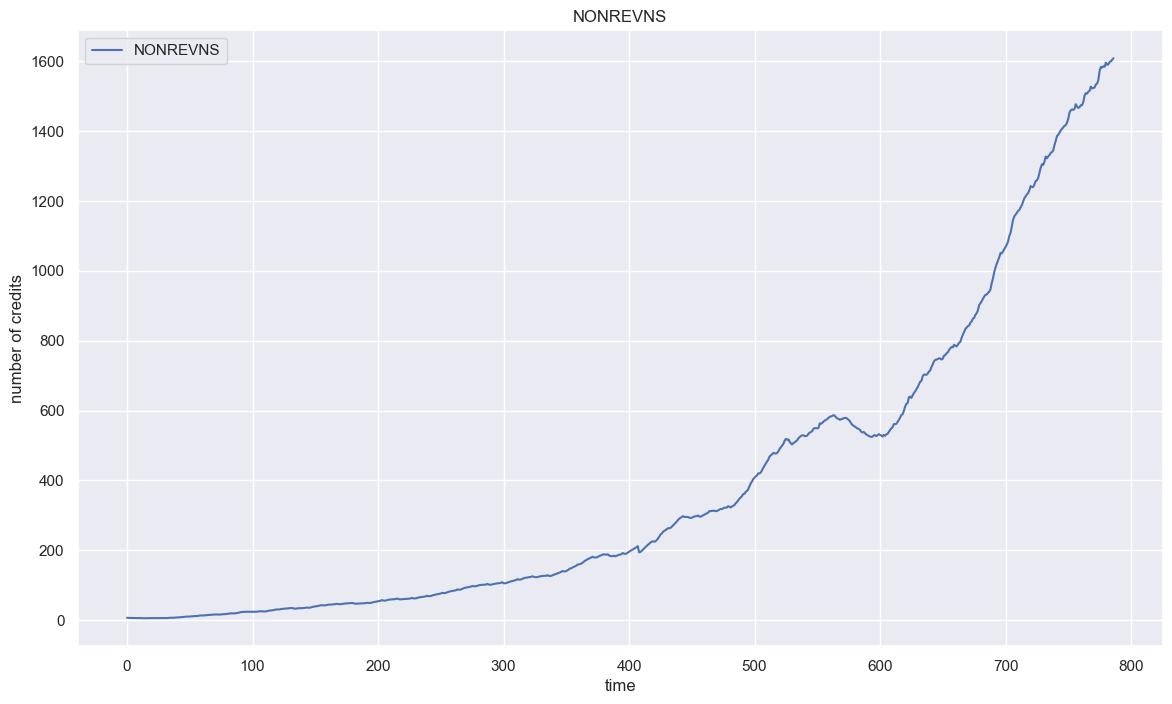

In [11]:
sns.lineplot(non_df).set(title='NONREVNS', xlabel='time', ylabel='number of credits')

[Text(0.5, 1.0, 'sqrt(NONREVNS)'),
 Text(0.5, 0, 'time'),
 Text(0, 0.5, 'number of credits')]

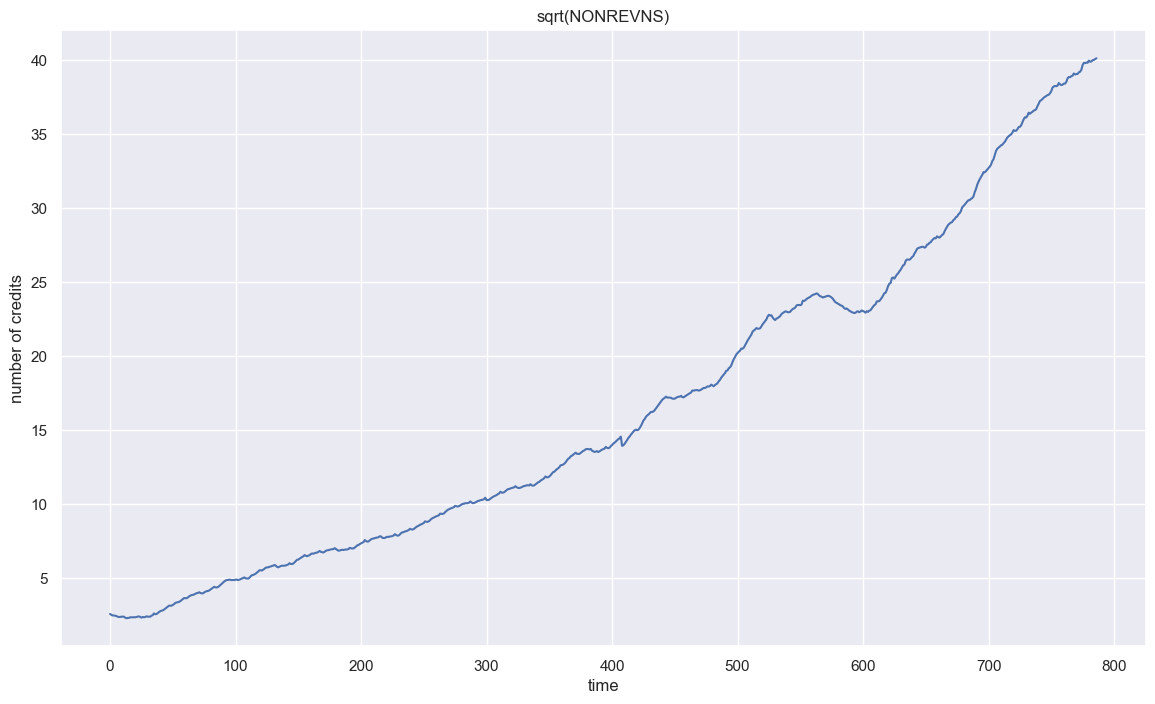

In [12]:
sns.lineplot(np.sqrt(non_df.squeeze())).set(title='sqrt(NONREVNS)', xlabel='time', ylabel='number of credits')

[Text(0.5, 1.0, 'log(NONREVNS)'),
 Text(0.5, 0, 'time'),
 Text(0, 0.5, 'number of credits')]

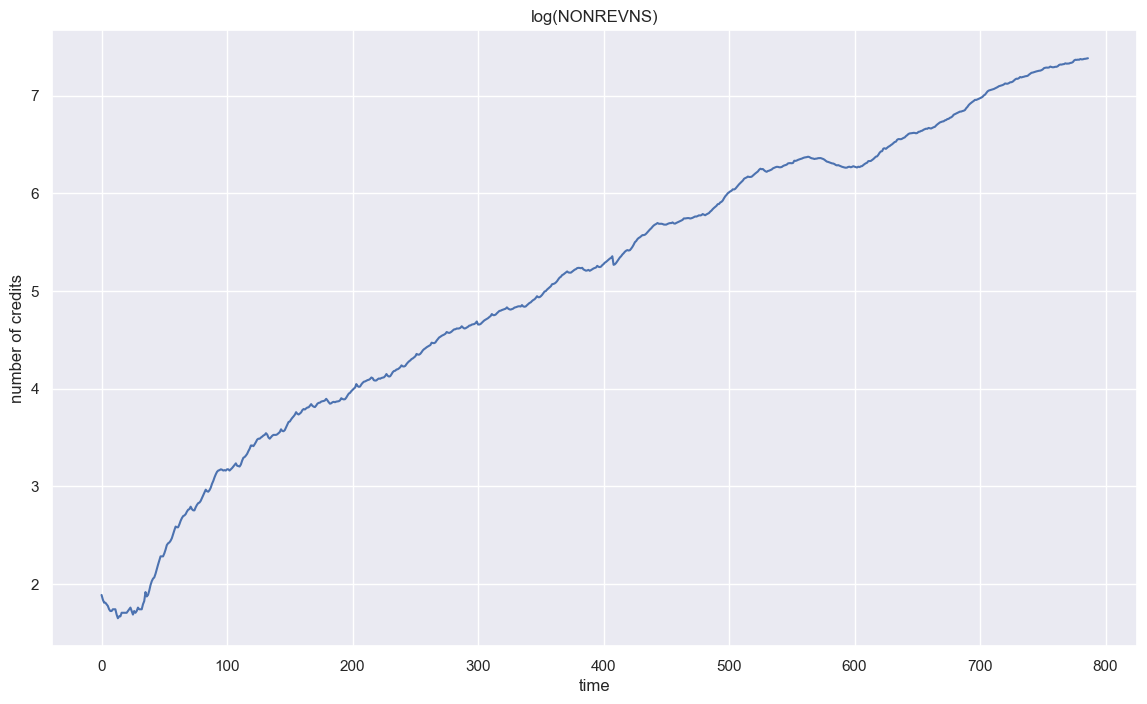

In [13]:
sns.lineplot(np.log(non_df.squeeze())).set(title='log(NONREVNS)', xlabel='time', ylabel='number of credits')

Логарифм краще не брати, візьмемо корінь

Як ми бачимо ми маємо тренд квадратичного степіня, тому що наші данні потім починають дуже різко зростати, 

набагато сильніше ніж у квадратичного, ?або кубічного?, тому потрібно створити датасет з поліноміальними дискретними щось там


## Поділимо дані:

In [14]:
non_df_sqrt = np.sqrt(non_df.squeeze())

X_non_df_train, X_non_df_test, y_non_df_train, y_non_df_test = train_test_split(non_df.index.values, non_df_sqrt, test_size=0.1, shuffle=False)

poly = PolynomialFeatures(degree=2)

X_non_df_train_poly = pd.DataFrame(poly.fit_transform(X_non_df_train.reshape(-1, 1)), columns=poly.get_feature_names_out())
X_non_df_test_poly = pd.DataFrame(poly.transform(X_non_df_test.reshape(-1, 1)), columns=poly.get_feature_names_out())
X_non_df_full_poly = pd.DataFrame(poly.transform(non_df.index.values.reshape(-1, 1)), columns=poly.get_feature_names_out())

## Модель у вигляді тренду:

In [15]:
mls_trend = MLS()

mls_trend.fit(X_non_df_train_poly, y_non_df_train)

predicted = mls_trend.predict(X_non_df_test_poly)

results = add_results(results, y_non_df_test, predicted)

trend_pred = predicted

print(f'coefs - {mls_trend.coefs} \n')
results

coefs - [array([2.54606938, 0.01617404, 0.00003531])] 



,S,R^2,IKA,DW,MSE,RMSE,MAE,MAPE,Theil-a
0,738.1058461949,0.7510274768,527.7228917502,0.0006784621,9.3431119772,3.0566504506,3.0406360995,8.1171397622,0.0000132564


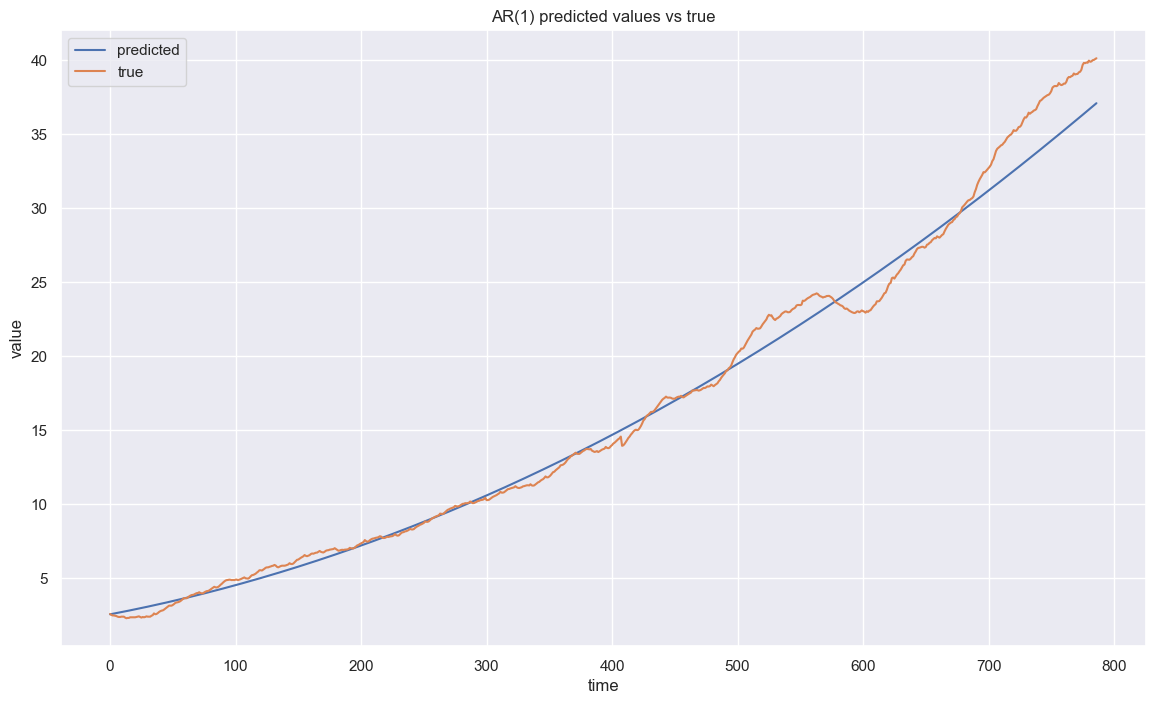

In [16]:
plt.plot(mls_trend.predict(X_non_df_full_poly), label='predicted')
# plt.plot(non_df, label='true')
plt.plot(non_df_sqrt, label='true')
plt.xlabel('time')
plt.ylabel('value')
plt.title('AR(1) predicted values vs true')
plt.legend()
plt.show()

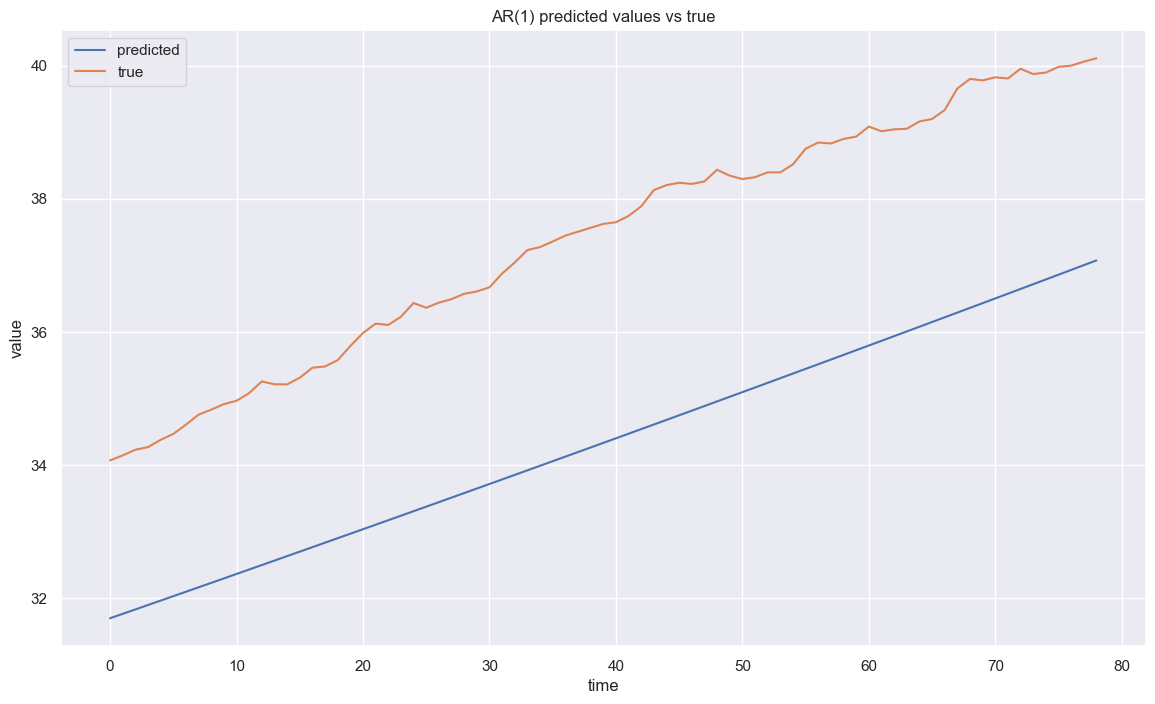

In [17]:
plt.plot(predicted, label='predicted')
plt.plot(y_non_df_test.values, label='true')
plt.xlabel('time')
plt.ylabel('value')
plt.title('AR(1) predicted values vs true')
plt.legend()
plt.show()

## ARIMA model

Підберемо d:

[Text(0.5, 1.0, 'sqrt(NONREVNS)'),
 Text(0.5, 0, 'time'),
 Text(0, 0.5, 'number of credits')]

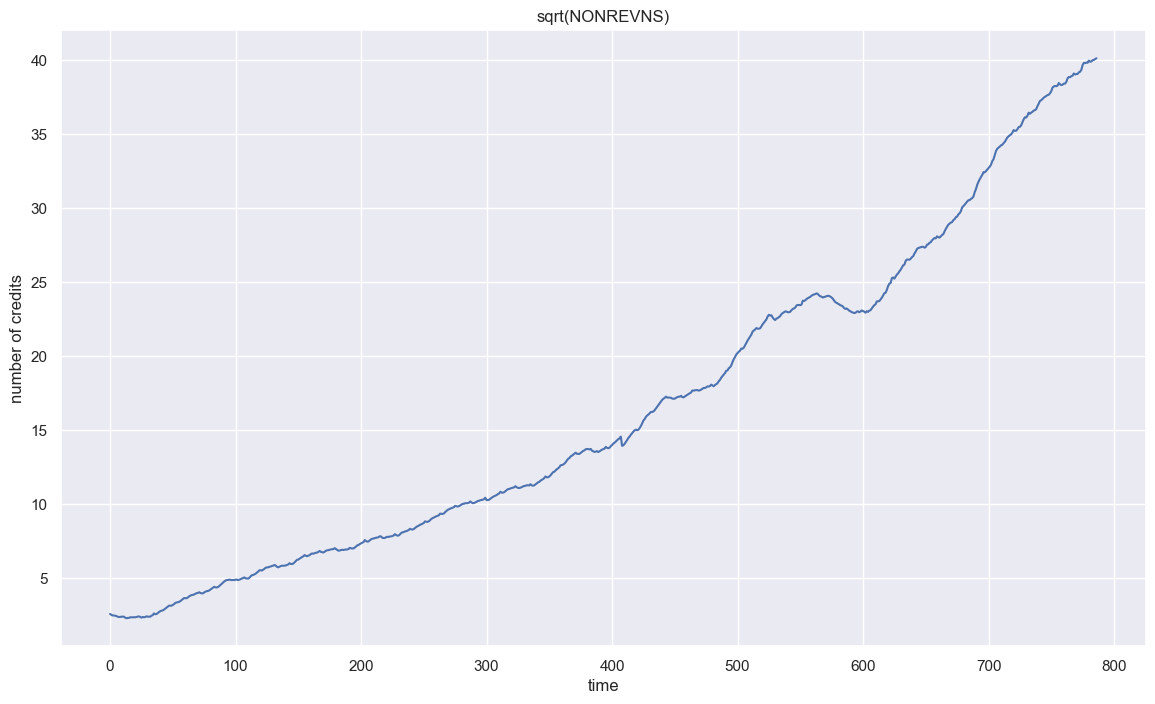

In [18]:
sns.lineplot(non_df_sqrt).set(title='sqrt(NONREVNS)', xlabel='time', ylabel='number of credits')

In [19]:
non_df_sqrt_diff = np.diff(non_df_sqrt, n=2)

[Text(0.5, 1.0, 'sqrt(NONREVNS), diff=2'),
 Text(0.5, 0, 'time'),
 Text(0, 0.5, 'number of credits')]

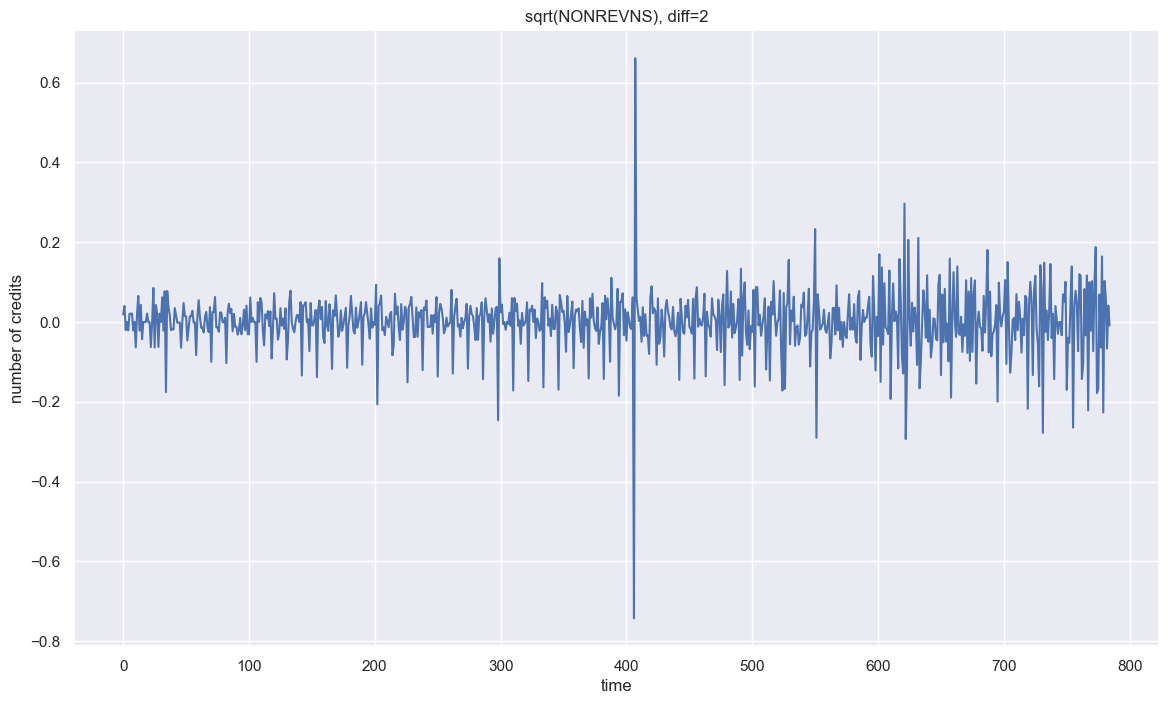

In [20]:
sns.lineplot(non_df_sqrt_diff).set(title='sqrt(NONREVNS), diff=2', xlabel='time', ylabel='number of credits')

### AR частина

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


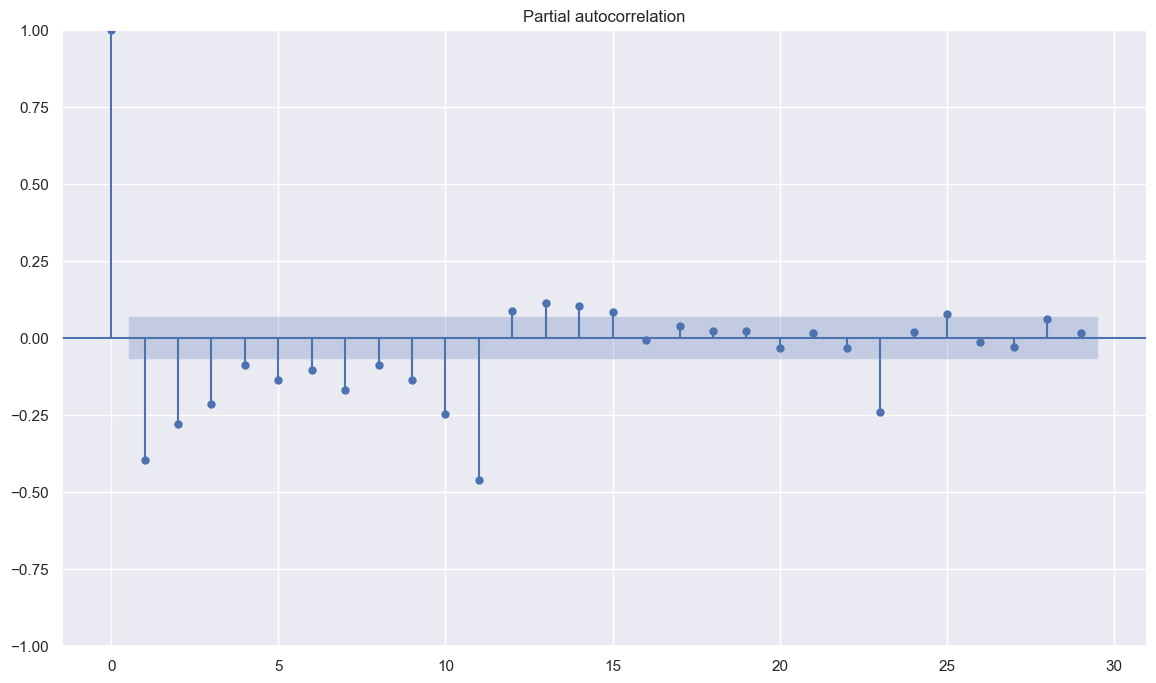

,autocorr
0,-0.3950044676
1,-0.0798968067
2,-0.0154225518
3,0.0600411816
4,-0.0723740920
5,0.0112099937
6,-0.0523216426
7,0.0654192864
8,-0.0545947496
9,-0.0666509288


In [21]:
pacf = pd.DataFrame({'autocorr': acf(non_df_sqrt_diff, nlags=12)[1:]})
                            # 'pacf': pacf(non_df_sqrt_diff, nlags=12)[1:]})
plot_pacf(non_df_sqrt_diff, title='Partial autocorrelation')
plt.show()
pacf

Як ми бачимо потрібно взяти, 1, 2, 10 та 11 лаги


In [22]:
non_df_sqrt_diff_lagged = pd.DataFrame({'a_0' : np.ones(len(shift(non_df_sqrt_diff, 1, cval=0))),
                                       'y_k_1' : shift(non_df_sqrt_diff, 1, cval=0),
                                       'y_k_2' : shift(non_df_sqrt_diff, 2, cval=0),
                                       'y_k_10' : shift(non_df_sqrt_diff, 10, cval=0),
                                       'y_k_11' : shift(non_df_sqrt_diff, 11, cval=0)})

X_non_df_train, X_non_df_test, y_non_df_train, y_non_df_test = train_test_split(non_df_sqrt_diff_lagged[11:],
                                                                                non_df_sqrt_diff[11:], test_size=0.1, shuffle=False)

### перед навчанням моделі додамо результати минулої у "скейлі"

In [23]:
results = add_results(results, y_non_df_test[1:], np.diff(predicted.squeeze(), n=2))
results

,S,R^2,IKA,DW,MSE,RMSE,MAE,MAPE,Theil-a
0,738.1058461949,0.7510274768,527.7228917502,0.0006784621,9.3431119772,3.0566504506,3.0406360995,8.1171397622,0.0000132564
1,0.8574694528,0.0000000000,-5.8402687582,2.7123429311,0.0111359669,0.1055270909,0.0843993967,101.9635162614,0.0000000000


In [24]:
pd.DataFrame(np.diff(np.sqrt(predicted.squeeze()))).describe()

,0
count,78.0000000000
mean,0.0058819756
std,0.0000027670
min,0.0058770918
25%,0.0058796537
50%,0.0058820687
75%,0.0058843476
max,0.0058865005


### Навчання моделі

In [25]:

mls_non_diff = MLS()

mls_non_diff.fit(X_non_df_train, y_non_df_train)

predicted = mls_non_diff.predict(X_non_df_test)

resid = pd.Series(non_df_sqrt_diff[1:] - mls_non_diff.predict(non_df_sqrt_diff_lagged[1:]))

results = add_results(results, y_non_df_test, predicted)

ar_pred = predicted

print(f'coefs - {mls_non_diff.coefs} \n')
results

coefs - [array([ 0.00046109, -0.53956672, -0.27954711, -0.16496351, -0.1922348 ])] 



,S,R^2,IKA,DW,MSE,RMSE,MAE,MAPE,Theil-a
0,738.1058461949,0.7510274768,527.7228917502,0.0006784621,9.3431119772,3.0566504506,3.0406360995,8.1171397622,0.0000132564
1,0.8574694528,0.0000000000,-5.8402687582,2.7123429311,0.0111359669,0.1055270909,0.0843993967,101.9635162614,0.0000000000
2,0.6019480348,0.2888869641,-33.5915643455,1.9828492890,0.0077172825,0.0878480648,0.0713122631,502.1404107482,1.1666942793


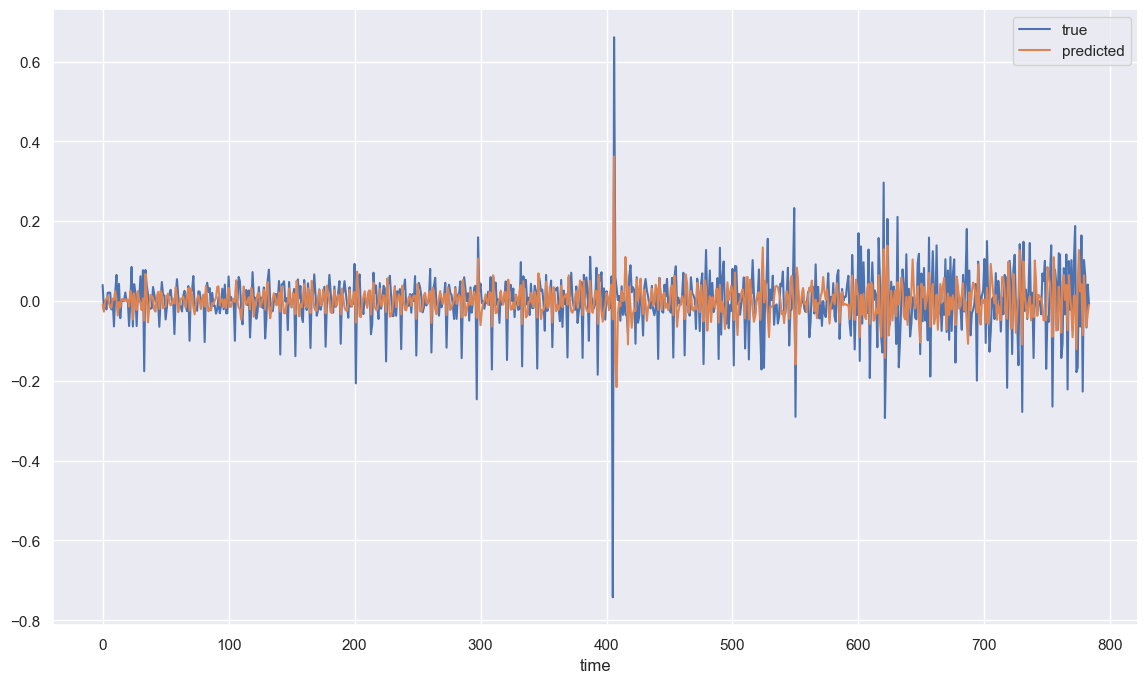

In [26]:
plt.plot(non_df_sqrt_diff[1:], label='true')
plt.plot(mls_non_diff.predict(non_df_sqrt_diff_lagged[1:]), label='predicted')
plt.xlabel('time')
plt.legend()

### MA частина

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


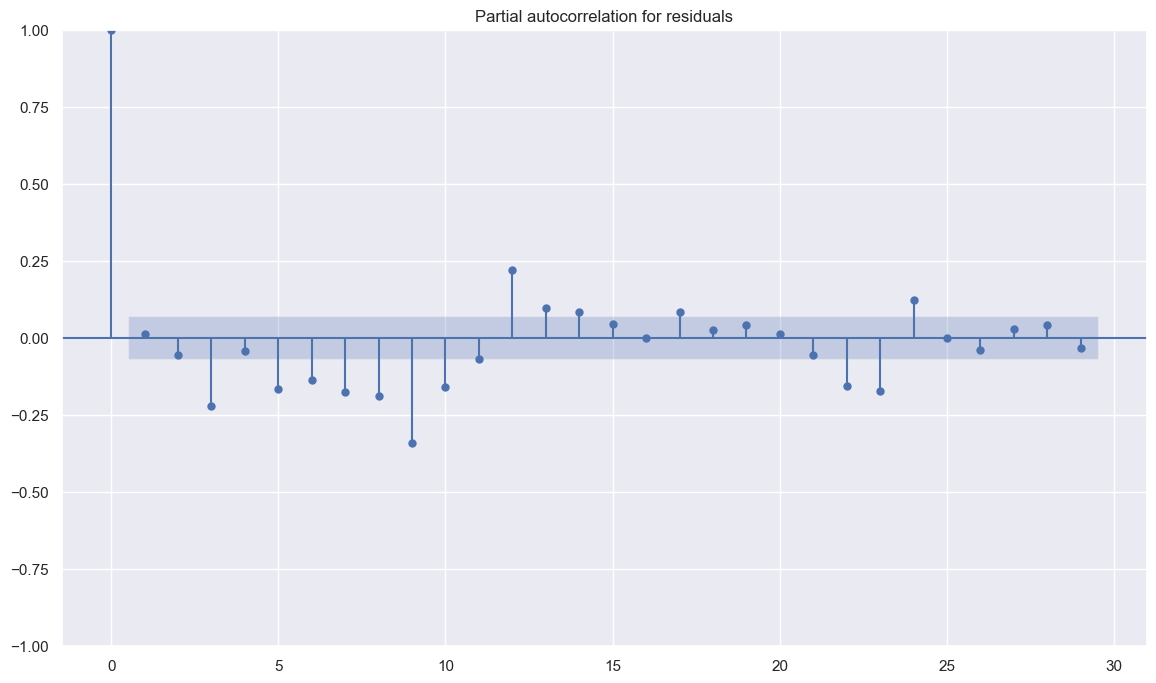

,autocorr
0,0.0113736514
1,-0.0556096714
2,-0.2221229454
3,-0.0396066578
4,-0.1323639057
5,-0.0662216805
6,-0.1116774000
7,-0.0603660351
8,-0.1697064107
9,0.0862942221


In [27]:
pacf_resid = pd.DataFrame({'autocorr': acf(resid, nlags=12)[1:]})
                            # 'pacf': pacf(resid, nlags=12)[1:]})
plot_pacf(resid, title='Partial autocorrelation for residuals')
plt.show()
pacf_resid

Додамо 3, 9 та 12 лаги

Поки що тільки ema з window = 5, можливо потім додати ще щось

In [28]:
ema_5 = calculate_ema(resid, 5)

ema_5_3 = shift(ema_5, 3, cval=0)
ema_5_9 = shift(ema_5, 9, cval=0)
ema_5_12 = shift(ema_5, 12, cval=0)

non_df_sqrt_diff_ma_lagged= pd.DataFrame({'a_0' : np.ones(len(shift(non_df_sqrt_diff, 1, cval=0)))[1:],
                                       'y_k_1' : shift(non_df_sqrt_diff, 1, cval=0)[1:],
                                       'y_k_2' : shift(non_df_sqrt_diff, 2, cval=0)[1:],
                                       'y_k_10' : shift(non_df_sqrt_diff, 10, cval=0)[1:],
                                       'y_k_11' : shift(non_df_sqrt_diff, 11, cval=0)[1:],
                                       'ema_5_3' : ema_5_3,
                                       'ema_5_9' : ema_5_9,
                                       'ema_5_12' : ema_5_12})

X_non_df_train_arima, X_non_df_test_arima, y_non_df_train_arima, y_non_df_test_arima = train_test_split(non_df_sqrt_diff_ma_lagged[16:], non_df_sqrt_diff[17:], test_size=0.1, shuffle=False)

### Навчання моделі ARIMA(4, 2, 3)

In [29]:
mls_arima = MLS()

mls_arima.fit(X_non_df_train_arima, y_non_df_train_arima)

predicted = mls_arima.predict(X_non_df_test_arima)

resid = pd.Series(non_df_sqrt_diff[17:] - mls_arima.predict(non_df_sqrt_diff_ma_lagged[16:]))

results = add_results(results, y_non_df_test_arima, predicted)

arima_pred = predicted

print(f'coefs - {mls_arima.coefs} \n')
results

coefs - [array([ 0.00042999, -0.75861426, -0.59099972, -0.06311548, -0.01964324,
       -1.17402497, -0.30731044,  1.12041977])] 



,S,R^2,IKA,DW,MSE,RMSE,MAE,MAPE,Theil-a
0,738.1058461949,0.7510274768,527.7228917502,0.0006784621,9.3431119772,3.0566504506,3.0406360995,8.1171397622,0.0000132564
1,0.8574694528,0.0000000000,-5.8402687582,2.7123429311,0.0111359669,0.1055270909,0.0843993967,101.9635162614,0.0000000000
2,0.6019480348,0.2888869641,-33.5915643455,1.9828492890,0.0077172825,0.0878480648,0.0713122631,502.1404107482,1.1666942793
3,0.4417465904,0.4658654200,-56.9104542435,2.1105321953,0.0057369687,0.0757427799,0.0620204827,1056.3765097690,0.2151616872


Як ми бачимо, ми отримали найкращу, на даний момент, модель 

### Dynamic predictions for ARIMA

In [30]:
rls_model = RLS(n_features=X_non_df_train_arima.shape[1])

rls_model.fit(X_non_df_train_arima.values, y_non_df_train_arima)

predicted = dynamic_predict_rls(rls_model, X_non_df_test_arima.values)

results = add_results(results, y_non_df_test_arima, predicted)

arima_dyn_pred = predicted

print(f'coefs - {rls_model.weights} \n')
results

coefs - [[ 0.00074271]
 [-0.2496984 ]
 [-0.0833947 ]
 [ 0.03130715]
 [ 0.04427665]
 [ 0.36309201]
 [ 0.19261944]
 [ 0.68955541]] 



C:\Users\Kidma\AppData\Local\Temp\ipykernel_27784\2906885277.py:31: RuntimeWarning: invalid value encountered in log
  theil_sum += p * np.log(income / mean_income)


,S,R^2,IKA,DW,MSE,RMSE,MAE,MAPE,Theil-a
0,738.1058461949,0.7510274768,527.7228917502,0.0006784621,9.3431119772,3.0566504506,3.0406360995,8.1171397622,0.0000132564
1,0.8574694528,0.0000000000,-5.8402687582,2.7123429311,0.0111359669,0.1055270909,0.0843993967,101.9635162614,0.0000000000
2,0.6019480348,0.2888869641,-33.5915643455,1.9828492890,0.0077172825,0.0878480648,0.0713122631,502.1404107482,1.1666942793
3,0.4417465904,0.4658654200,-56.9104542435,2.1105321953,0.0057369687,0.0757427799,0.0620204827,1056.3765097690,0.2151616872
4,0.6756763040,0.0854323782,-24.1871691525,2.4556171092,0.0087750169,0.0936750604,0.0759475877,615.7309748458,NaN


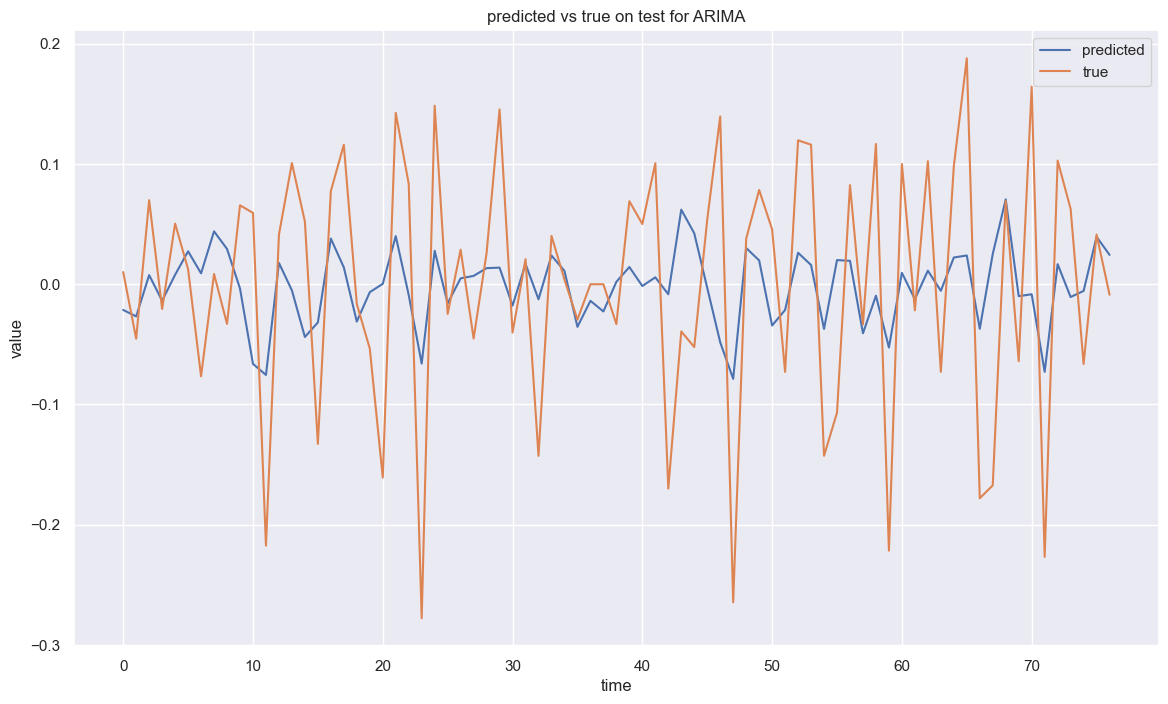

In [31]:
plt.plot(predicted, label='predicted')
plt.plot(y_non_df_test_arima, label='true')
plt.xlabel('time')
plt.ylabel('value')
plt.title('predicted vs true on test for ARIMA')
plt.legend()
plt.show()

## AR:

цю модель будемо також будувати для даних які спочатку були "закорінені"

### Знайдемо p

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


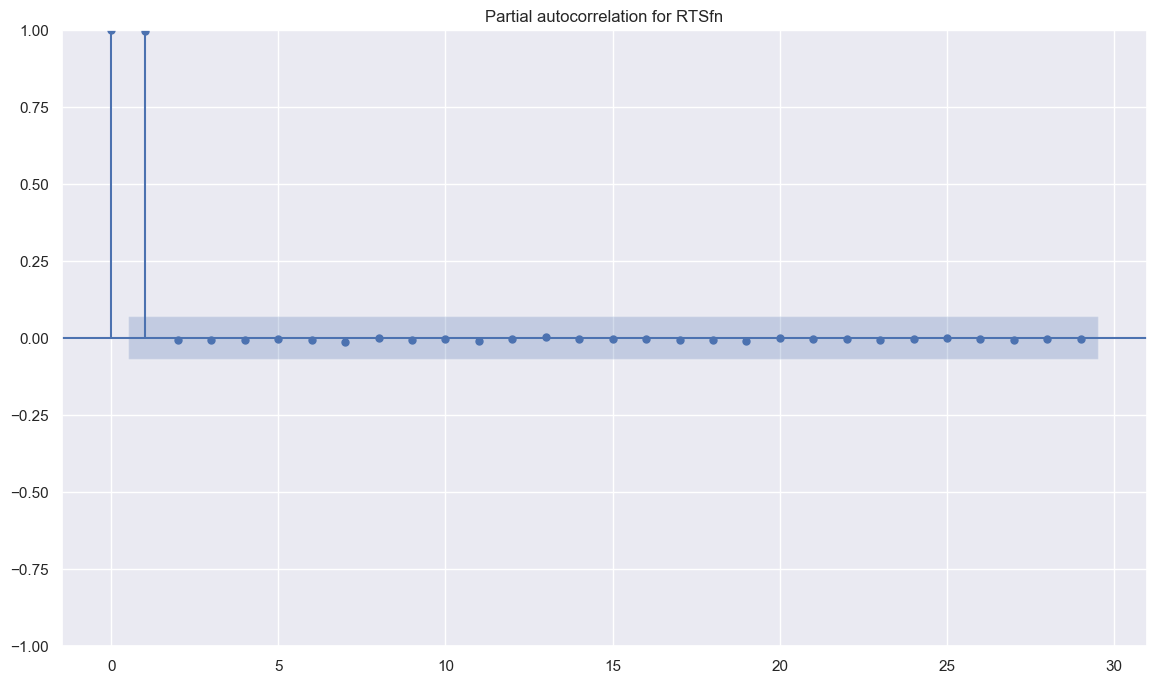

,autocorr
0,0.9958057558
1,0.9915772244
2,0.9873252035
3,0.9830464081
4,0.9787556074
5,0.9744400920
6,0.9700695604
7,0.9657070192
8,0.9613103866
9,0.9569007827


In [32]:
pacf_non_df_sqrt = pd.DataFrame({'autocorr': acf(non_df_sqrt, nlags=12)[1:]})
                            # 'pacf': pacf(non_df_sqrt, nlags=12)[1:]})
plot_pacf(non_df_sqrt, title='Partial autocorrelation for RTSfn')
plt.show()

pacf_non_df_sqrt

Очевидно, що p = 1 

In [33]:
non_df_sqrt_lagged = pd.DataFrame({'a_0' : np.ones(len(shift(non_df_sqrt, 1, cval=0))),
                                       'y_k_1' : shift(non_df_sqrt, 1, cval=0)})

X_non_sqrt_train_ar, X_non_sqrt_test_ar, y_non_sqrt_train_ar, y_non_sqrt_test_ar = train_test_split(non_df_sqrt_lagged[1:], non_df_sqrt[1:], test_size=0.1, shuffle=False)

### Статичні

In [34]:
mls_non_ar = MLS()

mls_non_ar.fit(X_non_sqrt_train_ar, y_non_sqrt_train_ar)

predicted = mls_non_ar.predict(X_non_sqrt_test_ar)

resid = pd.Series(non_df_sqrt[1:] - mls_non_ar.predict(non_df_sqrt_lagged[1:]))

results = add_results(results, y_non_sqrt_test_ar, predicted)

ar_pred = predicted

print(f'coefs - {mls_non_ar.coefs} \n')
results

coefs - [array([0.00912312, 1.00250179])] 



,S,R^2,IKA,DW,MSE,RMSE,MAE,MAPE,Theil-a
0,738.1058461949,0.7510274768,527.7228917502,0.0006784621,9.3431119772,3.0566504506,3.0406360995,8.1171397622,0.0000132564
1,0.8574694528,0.0000000000,-5.8402687582,2.7123429311,0.0111359669,0.1055270909,0.0843993967,101.9635162614,0.0000000000
2,0.6019480348,0.2888869641,-33.5915643455,1.9828492890,0.0077172825,0.0878480648,0.0713122631,502.1404107482,1.1666942793
3,0.4417465904,0.4658654200,-56.9104542435,2.1105321953,0.0057369687,0.0757427799,0.0620204827,1056.3765097690,0.2151616872
4,0.6756763040,0.0854323782,-24.1871691525,2.4556171092,0.0087750169,0.0936750604,0.0759475877,615.7309748458,NaN
5,0.5533534801,1.0190460713,-40.7489038996,1.5535114014,0.0070044744,0.0836927382,0.0673160313,0.1784303015,0.0000152232


точно лагнуті, модель себе просто дуже гарно показує

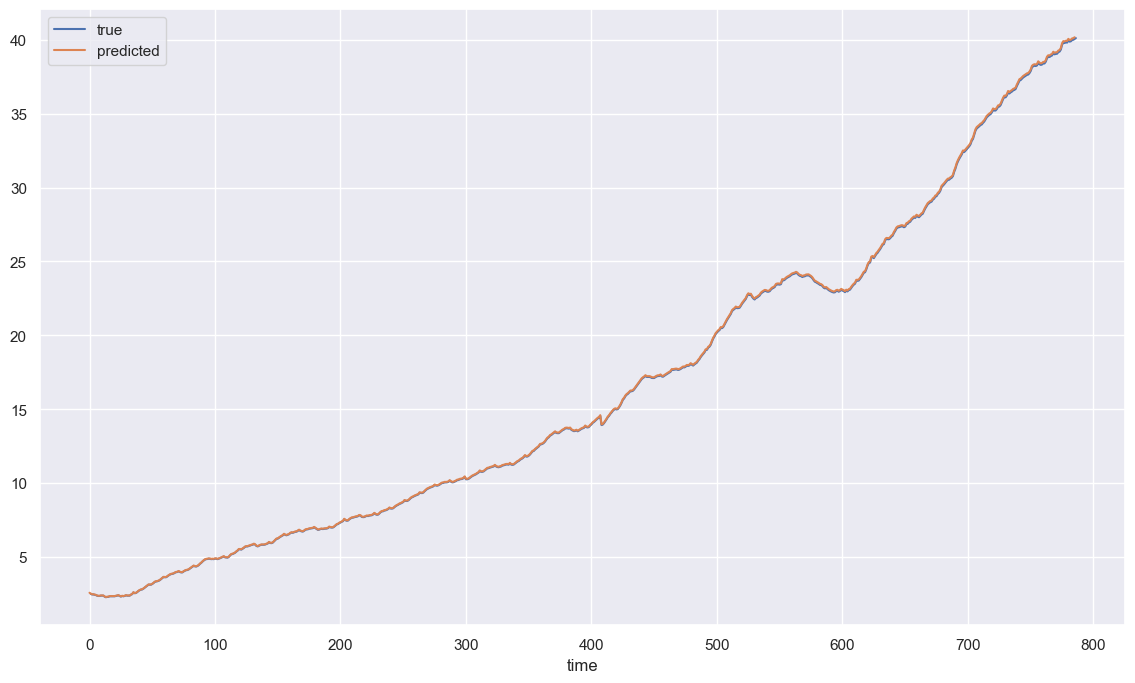

In [35]:
plt.plot(non_df_sqrt[1:], label='true')
plt.plot(mls_non_ar.predict(non_df_sqrt_lagged[1:]), label='predicted')
plt.xlabel('time')
plt.legend()

### Динамічні для AR

In [36]:
rls_model = RLS(n_features=X_non_sqrt_train_ar.shape[1])

rls_model.fit(X_non_sqrt_train_ar.values, y_non_sqrt_train_ar.values)

predicted = dynamic_predict_rls(rls_model, X_non_sqrt_test_ar.values)

results = add_results(results, y_non_sqrt_test_ar, predicted)

ar_dyn_pred = predicted

print(f'coefs - {rls_model.weights} \n')
results

coefs - [[0.01427359]
 [1.00223059]] 



,S,R^2,IKA,DW,MSE,RMSE,MAE,MAPE,Theil-a
0,738.1058461949,0.7510274768,527.7228917502,0.0006784621,9.3431119772,3.0566504506,3.0406360995,8.1171397622,0.0000132564
1,0.8574694528,0.0000000000,-5.8402687582,2.7123429311,0.0111359669,0.1055270909,0.0843993967,101.9635162614,0.0000000000
2,0.6019480348,0.2888869641,-33.5915643455,1.9828492890,0.0077172825,0.0878480648,0.0713122631,502.1404107482,1.1666942793
3,0.4417465904,0.4658654200,-56.9104542435,2.1105321953,0.0057369687,0.0757427799,0.0620204827,1056.3765097690,0.2151616872
4,0.6756763040,0.0854323782,-24.1871691525,2.4556171092,0.0087750169,0.0936750604,0.0759475877,615.7309748458,NaN
5,0.5533534801,1.0190460713,-40.7489038996,1.5535114014,0.0070044744,0.0836927382,0.0673160313,0.1784303015,0.0000152232
6,0.5341372160,1.0184947899,-43.5410986274,1.6089620591,0.0067612306,0.0822267024,0.0656122337,0.1739558411,0.0000152190


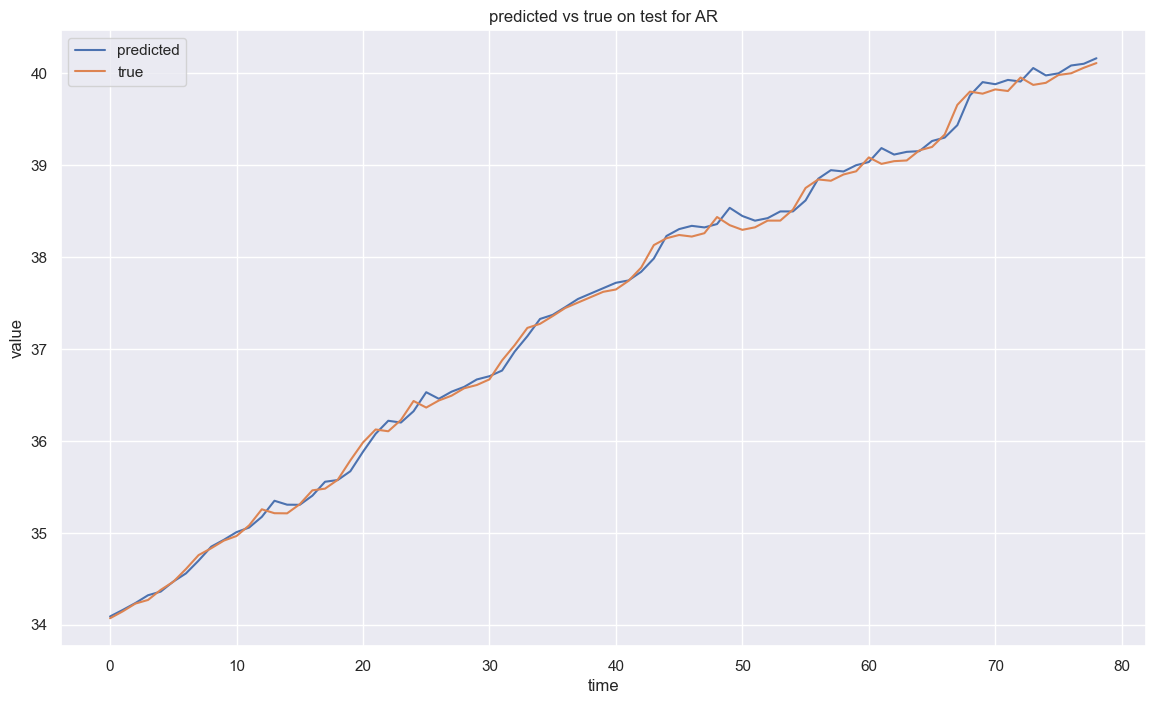

In [37]:
plt.plot(predicted, label='predicted')
plt.plot(y_non_sqrt_test_ar.values, label='true')
plt.xlabel('time')
plt.ylabel('value')
plt.title('predicted vs true on test for AR')
plt.legend()
plt.show()

## ARMA, цю модель будемо будувати по вихідному сигналу

Використовувати будемо ema з вікном у 5, як і минулого разу

In [38]:
ema_5 = calculate_ema(resid.values, 5)
ema_5_1 = shift(ema_5, 1, cval=0)

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


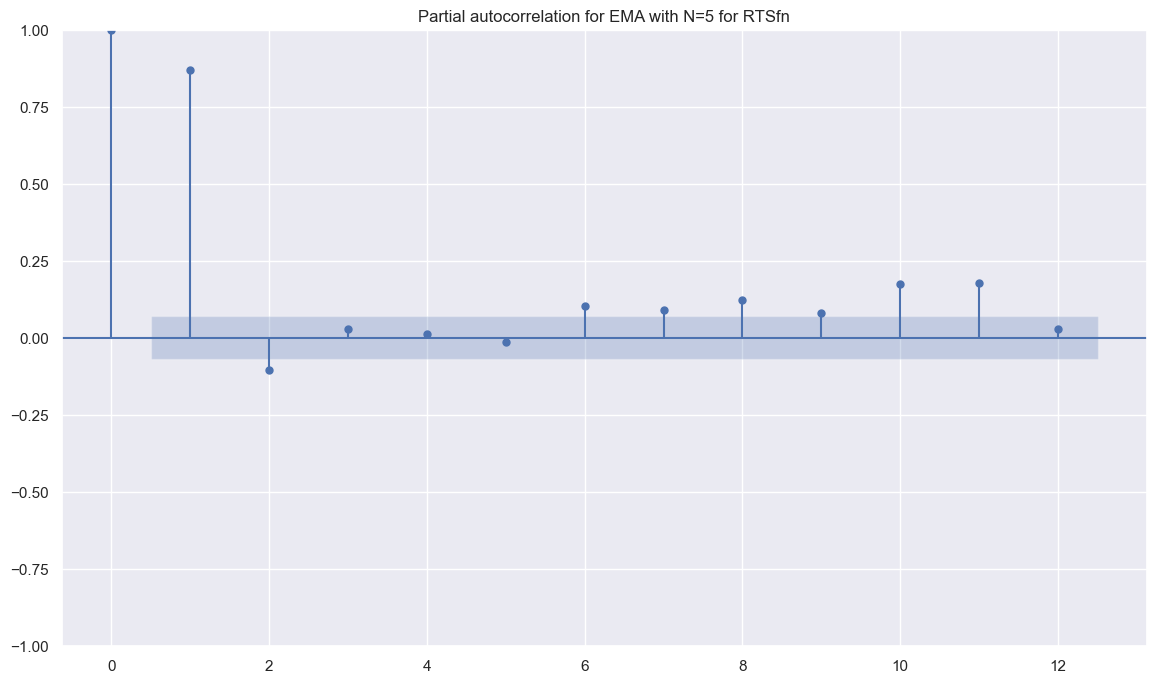

,autocorr
0,0.8678033745
1,0.7273016752
2,0.6129604301
3,0.5206099762
4,0.4394259514
5,0.3951072475
6,0.3811709156
7,0.3955081703
8,0.4195900287
9,0.4691343906


In [39]:
pacf = pd.DataFrame({'autocorr': acf(ema_5[4:], nlags=12)[1:]})
                    #  'pacf': pacf(ema_5[4:], nlags=12)[1:]}) 
                    # error - 'DataFrame' object is not callable
plot_pacf(ema_5[4:], title='Partial autocorrelation for EMA with N=5 for RTSfn', lags=12)
plt.show()

pacf

q = 1

In [40]:
non_df_sqrt_lagged_ma = pd.DataFrame({'a_0' : np.ones(len(ema_5)),
                                       'y_k_1' : shift(non_df_sqrt, 1, cval=0)[1:],
                                       'ema_5_1': ema_5_1})

X_non_sqrt_train, X_non_sqrt_test, \
y_non_sqrt_train, y_non_sqrt_test = train_test_split(non_df_sqrt_lagged_ma[5:], non_df_sqrt[6:], test_size=0.1, shuffle=False)

In [41]:
mls_non_arma = MLS()

mls_non_arma.fit(X_non_sqrt_train, y_non_sqrt_train)

predicted = mls_non_arma.predict(X_non_sqrt_test)

resid = pd.Series(non_df_sqrt[6:] - mls_non_arma.predict(non_df_sqrt_lagged_ma[5:]))

results = add_results(results, y_non_sqrt_test, predicted)

arma_pred = predicted

print(f'coefs - {mls_non_arma.coefs} \n')
results

coefs - [array([0.00991886, 1.00248191, 0.650095  ])] 



,S,R^2,IKA,DW,MSE,RMSE,MAE,MAPE,Theil-a
0,738.1058461949,0.7510274768,527.7228917502,0.0006784621,9.3431119772,3.0566504506,3.0406360995,8.1171397622,0.0000132564
1,0.8574694528,0.0000000000,-5.8402687582,2.7123429311,0.0111359669,0.1055270909,0.0843993967,101.9635162614,0.0000000000
2,0.6019480348,0.2888869641,-33.5915643455,1.9828492890,0.0077172825,0.0878480648,0.0713122631,502.1404107482,1.1666942793
3,0.4417465904,0.4658654200,-56.9104542435,2.1105321953,0.0057369687,0.0757427799,0.0620204827,1056.3765097690,0.2151616872
4,0.6756763040,0.0854323782,-24.1871691525,2.4556171092,0.0087750169,0.0936750604,0.0759475877,615.7309748458,NaN
5,0.5533534801,1.0190460713,-40.7489038996,1.5535114014,0.0070044744,0.0836927382,0.0673160313,0.1784303015,0.0000152232
6,0.5341372160,1.0184947899,-43.5410986274,1.6089620591,0.0067612306,0.0822267024,0.0656122337,0.1739558411,0.0000152190
7,0.5589182397,1.0036568402,-39.9584141867,1.8995110980,0.0070749144,0.0841125105,0.0662847053,0.1767496413,0.0000150017


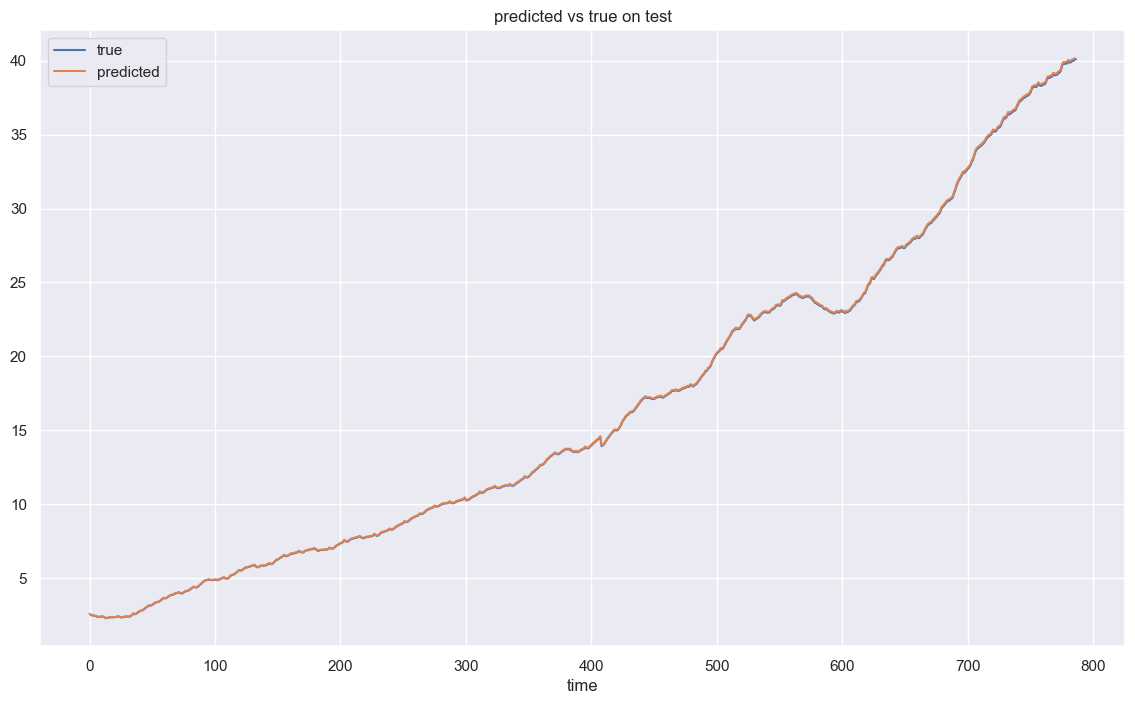

In [42]:
plt.plot(non_df_sqrt[1:], label='true')
plt.plot(mls_non_ar.predict(non_df_sqrt_lagged[1:]), label='predicted')
plt.xlabel('time')
plt.title('predicted vs true on test')
plt.legend()

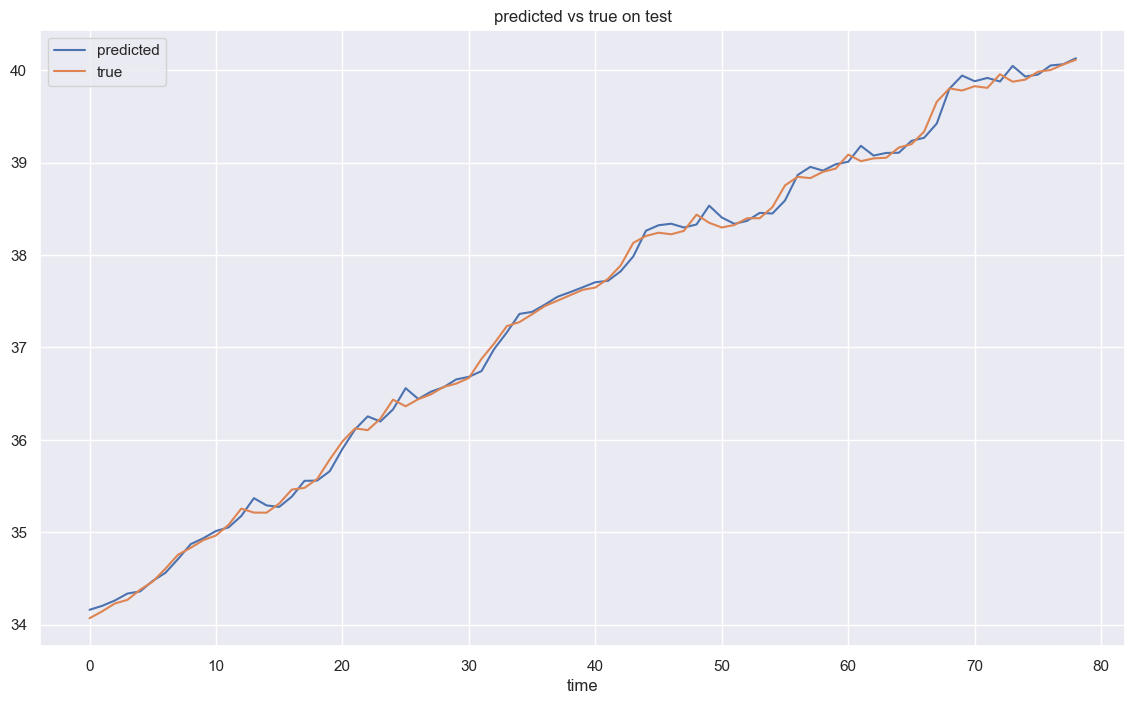

In [43]:
plt.plot(predicted, label='predicted')
plt.plot(y_non_sqrt_test.values, label='true')
plt.xlabel('time')
plt.title('predicted vs true on test')
plt.legend()
plt.show()

### Dynamic predictions for ARMA

In [44]:
rls_model = RLS(n_features=X_non_sqrt_train.shape[1])

rls_model.fit(X_non_sqrt_train.values, y_non_sqrt_train.values)

predicted = dynamic_predict_rls(rls_model, X_non_sqrt_test.values)

results = add_results(results, y_non_sqrt_test, predicted)

arma_dyn_pred = predicted

print(f'coefs - {rls_model.weights} \n')
results

coefs - [[0.0121231 ]
 [1.00235781]
 [0.43483875]] 



,S,R^2,IKA,DW,MSE,RMSE,MAE,MAPE,Theil-a
0,738.1058461949,0.7510274768,527.7228917502,0.0006784621,9.3431119772,3.0566504506,3.0406360995,8.1171397622,0.0000132564
1,0.8574694528,0.0000000000,-5.8402687582,2.7123429311,0.0111359669,0.1055270909,0.0843993967,101.9635162614,0.0000000000
2,0.6019480348,0.2888869641,-33.5915643455,1.9828492890,0.0077172825,0.0878480648,0.0713122631,502.1404107482,1.1666942793
3,0.4417465904,0.4658654200,-56.9104542435,2.1105321953,0.0057369687,0.0757427799,0.0620204827,1056.3765097690,0.2151616872
4,0.6756763040,0.0854323782,-24.1871691525,2.4556171092,0.0087750169,0.0936750604,0.0759475877,615.7309748458,NaN
5,0.5533534801,1.0190460713,-40.7489038996,1.5535114014,0.0070044744,0.0836927382,0.0673160313,0.1784303015,0.0000152232
6,0.5341372160,1.0184947899,-43.5410986274,1.6089620591,0.0067612306,0.0822267024,0.0656122337,0.1739558411,0.0000152190
7,0.5589182397,1.0036568402,-39.9584141867,1.8995110980,0.0070749144,0.0841125105,0.0662847053,0.1767496413,0.0000150017
8,0.5356090388,1.0084399517,-43.3237123567,1.8450335321,0.0067798613,0.0823399129,0.0654014419,0.1741052654,0.0000150723


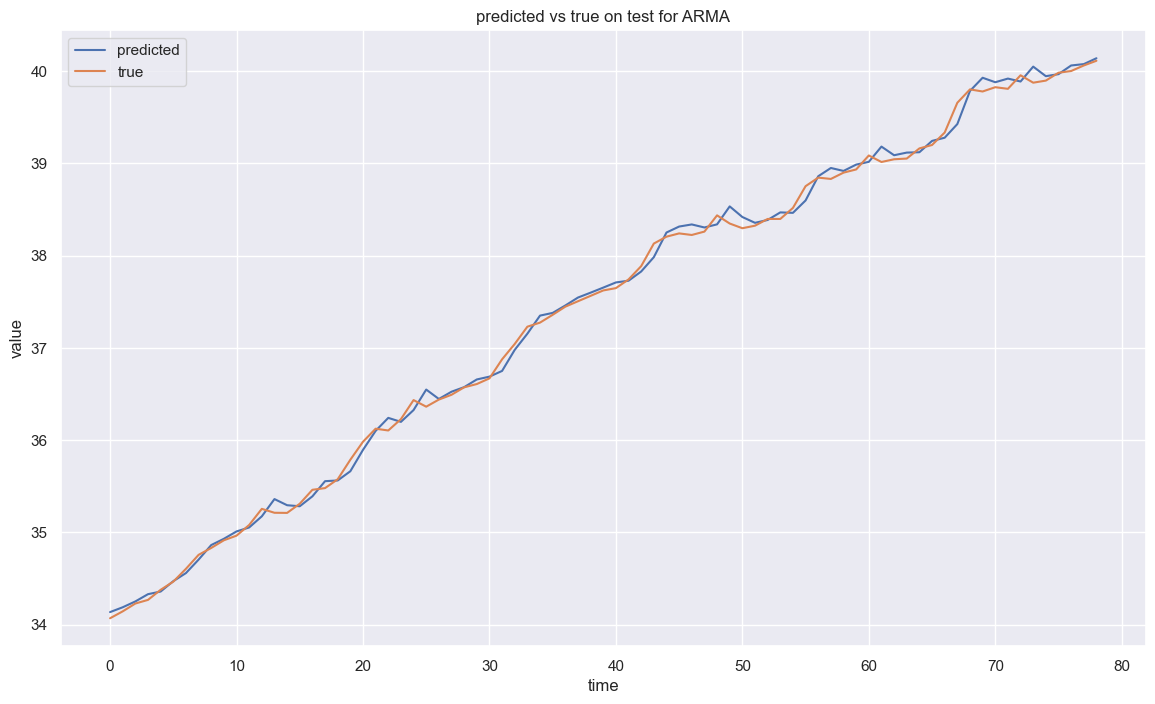

In [45]:
plt.plot(predicted, label='predicted')
plt.plot(y_non_sqrt_test.values, label='true')
plt.xlabel('time')
plt.ylabel('value')
plt.title('predicted vs true on test for ARMA')
plt.legend()
plt.show()

# NONREVNS results

In [46]:
pd.DataFrame({'Реальне значення sqrt y': y_non_sqrt_test[2:],
              'Тренд 2-го порядку': trend_pred[2:],
              'АРІКС (4, 2, 3)': arima_pred,
              'АР(1)': ar_pred[2:],
              'АРКС(1, 1)': arma_pred[2:]})

C:\Users\Kidma\AppData\Local\Temp\ipykernel_27784\1928434462.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  pd.DataFrame({'Реальне значення sqrt y': y_non_sqrt_test[2:],


,Реальне значення sqrt y,Тренд 2-го порядку,"АРІКС (4, 2, 3)",АР(1),"АРКС(1, 1)"
710,34.2301037100,31.8307100226,0.0016101458,34.2398254482,34.2621800878
711,34.2695199850,31.8970632396,0.0462035288,34.3248635171,34.3376971406
712,34.3787725203,31.9634870818,0.0925677500,34.3643784034,34.3609788570
713,34.4673758792,32.0299815491,0.0231101072,34.4739042661,34.4747929885
714,34.6063577974,32.0965466416,0.0317239134,34.5627292925,34.5619426754
...,...,...,...,...,...
782,39.8973683343,36.7886595563,0.1140353189,39.9836857627,39.9303711948
783,39.9824961702,36.8600977849,0.0196956760,40.0063064734,39.9520590579
784,40.0012499805,36.9316066385,-0.0553464329,40.0916472817,40.0503217639
785,40.0612031771,37.0031861174,0.0355374611,40.1104480101,40.0633085550


In [47]:
pd.DataFrame({'Реальне значення sqrt y': y_non_sqrt_test[2:],
              'АРІКС (4, 2, 3) динамічний': arima_dyn_pred,
              'АР(1), динамічний': ar_dyn_pred[2:],
              'АРКС(1, 1), динамічний': arma_dyn_pred[2:]})

C:\Users\Kidma\AppData\Local\Temp\ipykernel_27784\4159718188.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  pd.DataFrame({'Реальне значення sqrt y': y_non_sqrt_test[2:],


,Реальне значення sqrt y,"АРІКС (4, 2, 3) динамічний","АР(1), динамічний","АРКС(1, 1), динамічний"
710,34.2301037100,-0.0214750311,34.2357156369,34.2527835165
711,34.2695199850,-0.0268433510,34.3207307008,34.3314420355
712,34.3787725203,0.0075035333,34.3602348974,34.3600936477
713,34.4673758792,-0.0138383229,34.4697311305,34.4724735910
714,34.6063577974,0.0077710150,34.5585321275,34.5601664288
...,...,...,...,...
782,39.8973683343,0.0166002283,39.9780220904,39.9452810649
783,39.9824961702,-0.0107144819,40.0006366816,39.9672748591
784,40.0012499805,-0.0056686123,40.0859544030,40.0612478051
785,40.0612031771,0.0393804579,40.1047500454,40.0761572275


In [48]:
idx = ['Тренд', 'тренд у скейлі', 'АРІ(4, 2)', 'АРІКС(4, 2, 3)', 'АРІКС(4, 2, 3) динам',
       'АР(1)', 'АР(1) динамічний', 'АРКС(1, 1)', 'АРКС(1, 1) динамічний']

results.set_index(pd.Index(idx)).loc[['Тренд', 'АРІ(4, 2)', 'АРІКС(4, 2, 3)', 'АР(1)', 'АРКС(1, 1)']].T

,Тренд,"АРІ(4, 2)","АРІКС(4, 2, 3)",АР(1),"АРКС(1, 1)"
S,738.1058461949,0.6019480348,0.4417465904,0.5533534801,0.5589182397
R^2,0.7510274768,0.2888869641,0.4658654200,1.0190460713,1.0036568402
IKA,527.7228917502,-33.5915643455,-56.9104542435,-40.7489038996,-39.9584141867
DW,0.0006784621,1.9828492890,2.1105321953,1.5535114014,1.8995110980
MSE,9.3431119772,0.0077172825,0.0057369687,0.0070044744,0.0070749144
RMSE,3.0566504506,0.0878480648,0.0757427799,0.0836927382,0.0841125105
MAE,3.0406360995,0.0713122631,0.0620204827,0.0673160313,0.0662847053
MAPE,8.1171397622,502.1404107482,1056.3765097690,0.1784303015,0.1767496413
Theil-a,0.0000132564,1.1666942793,0.2151616872,0.0000152232,0.0000150017


In [49]:
results.set_index(pd.Index(idx)).loc[['АРІКС(4, 2, 3) динам', 'АР(1) динамічний', 'АРКС(1, 1) динамічний']].T

,"АРІКС(4, 2, 3) динам",АР(1) динамічний,"АРКС(1, 1) динамічний"
S,0.6756763040,0.5341372160,0.5356090388
R^2,0.0854323782,1.0184947899,1.0084399517
IKA,-24.1871691525,-43.5410986274,-43.3237123567
DW,2.4556171092,1.6089620591,1.8450335321
MSE,0.0087750169,0.0067612306,0.0067798613
RMSE,0.0936750604,0.0822267024,0.0823399129
MAE,0.0759475877,0.0656122337,0.0654014419
MAPE,615.7309748458,0.1739558411,0.1741052654
Theil-a,NaN,0.0000152190,0.0000150723


C:\Users\Kidma\AppData\Local\Temp\ipykernel_27784\2436779902.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(y_non_sqrt_test[2:].values, label='Реальне значення sqrt y')


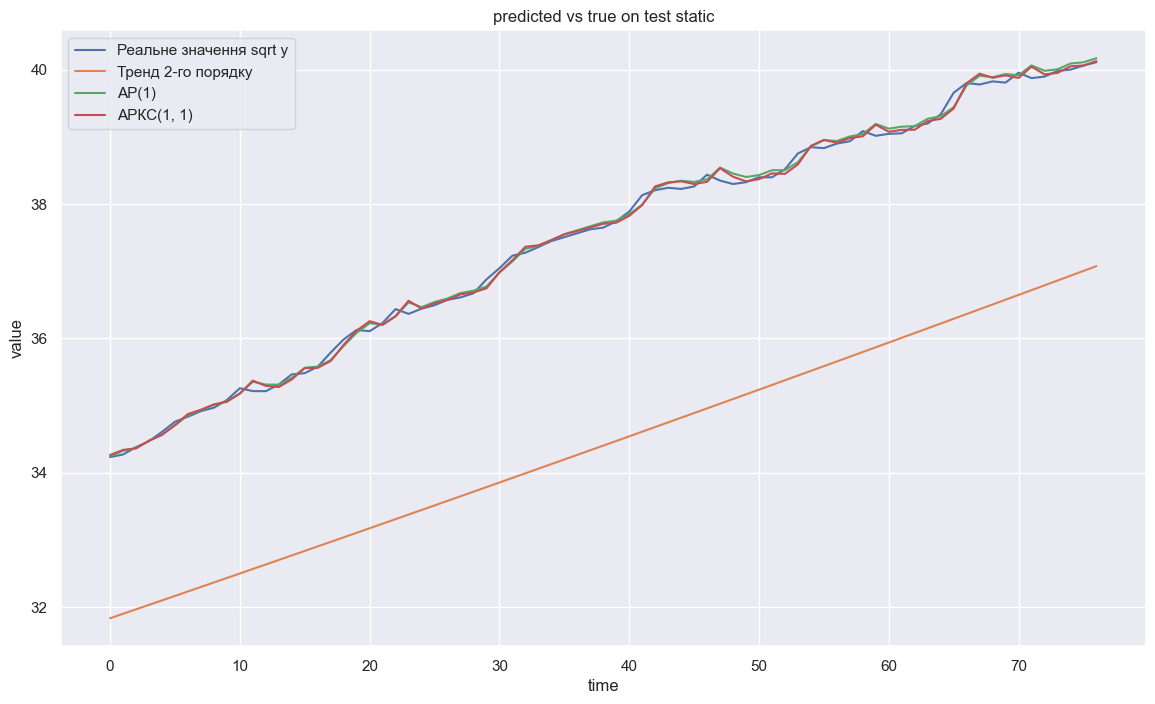

In [50]:
plt.plot(y_non_sqrt_test[2:].values, label='Реальне значення sqrt y')
plt.plot(trend_pred[2:], label='Тренд 2-го порядку')
plt.plot(ar_pred[2:], label='АР(1)')
plt.plot(arma_pred[2:], label='АРКС(1, 1)')
plt.xlabel('time')
plt.ylabel('value')
plt.title('predicted vs true on test static')
plt.legend()
plt.show()

C:\Users\Kidma\AppData\Local\Temp\ipykernel_27784\631853459.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(y_non_sqrt_test[2:].values, label='Реальне значення sqrt y')


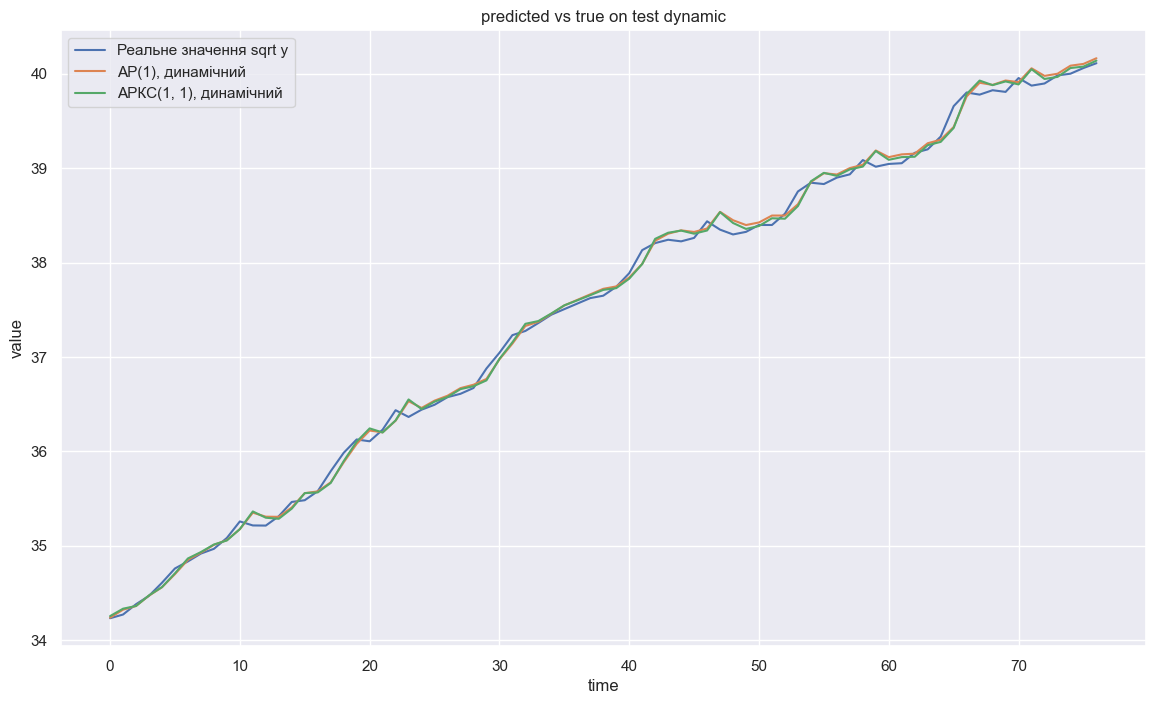

In [51]:
plt.plot(y_non_sqrt_test[2:].values, label='Реальне значення sqrt y')
plt.plot(ar_dyn_pred[2:], label='АР(1), динамічний')
plt.plot(arma_dyn_pred[2:], label='АРКС(1, 1), динамічний')
plt.xlabel('time')
plt.ylabel('value')
plt.title('predicted vs true on test dynamic')
plt.legend()
plt.show()

# Revolns

In [52]:
Revolns.describe()

,Revolns
count,487.0000000000
mean,296.1260780287
std,302.8479152839
min,1.4000000000
25%,38.6000000000
50%,168.6000000000
75%,556.9500000000
max,969.5000000000


Як ми бачимо значення нашого датасету не дуже великі, тому логарифмування, або інші трансформації для зменшення діапазон значень не потрібні

[Text(0.5, 1.0, 'Revolns'),
 Text(0.5, 0, 'time'),
 Text(0, 0.5, 'number of credits')]

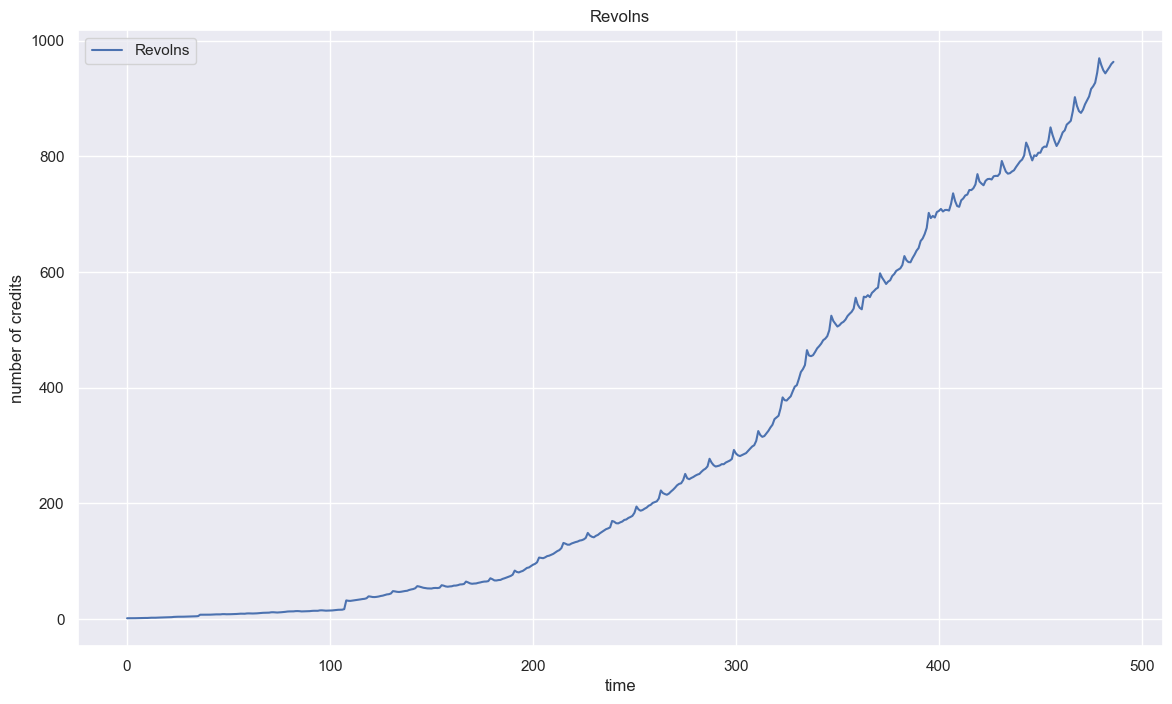

In [53]:
sns.lineplot(Revolns).set(title='Revolns', xlabel='time', ylabel='number of credits')

[Text(0.5, 1.0, 'sqrt(Revolns)'),
 Text(0.5, 0, 'time'),
 Text(0, 0.5, 'number of credits')]

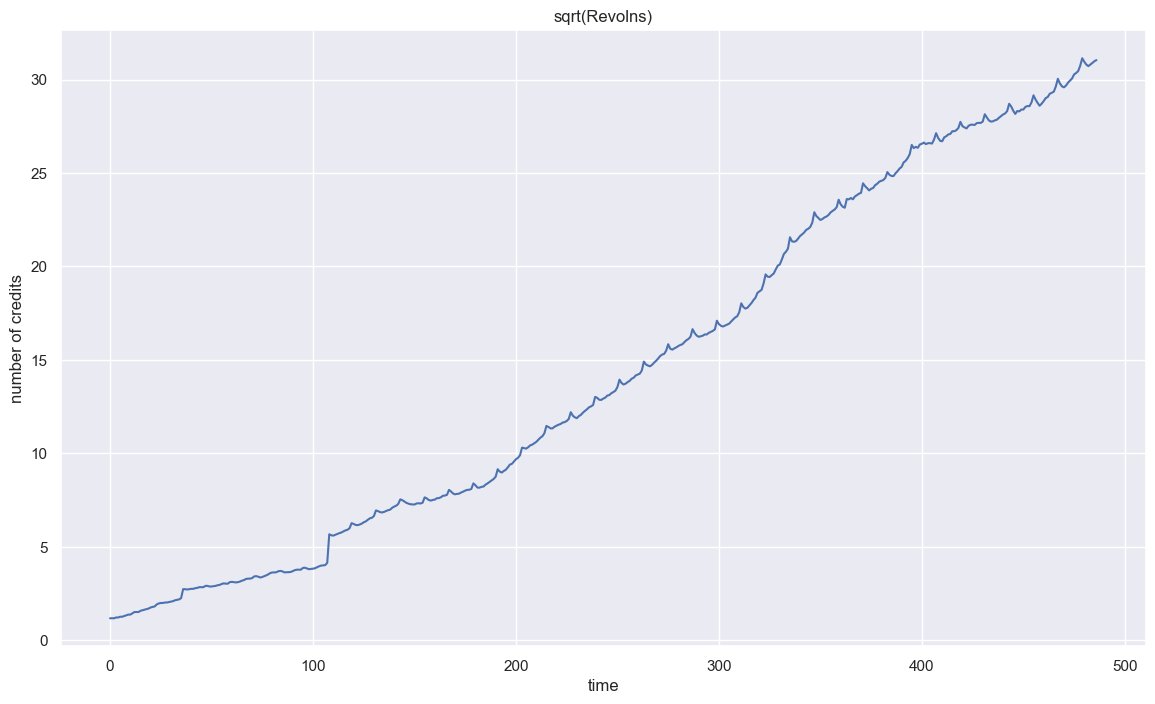

In [54]:
sns.lineplot(np.sqrt(Revolns.squeeze())).set(title='sqrt(Revolns)', xlabel='time', ylabel='number of credits')

[Text(0.5, 1.0, 'sqrt(Revolns)'),
 Text(0.5, 0, 'time'),
 Text(0, 0.5, 'number of credits')]

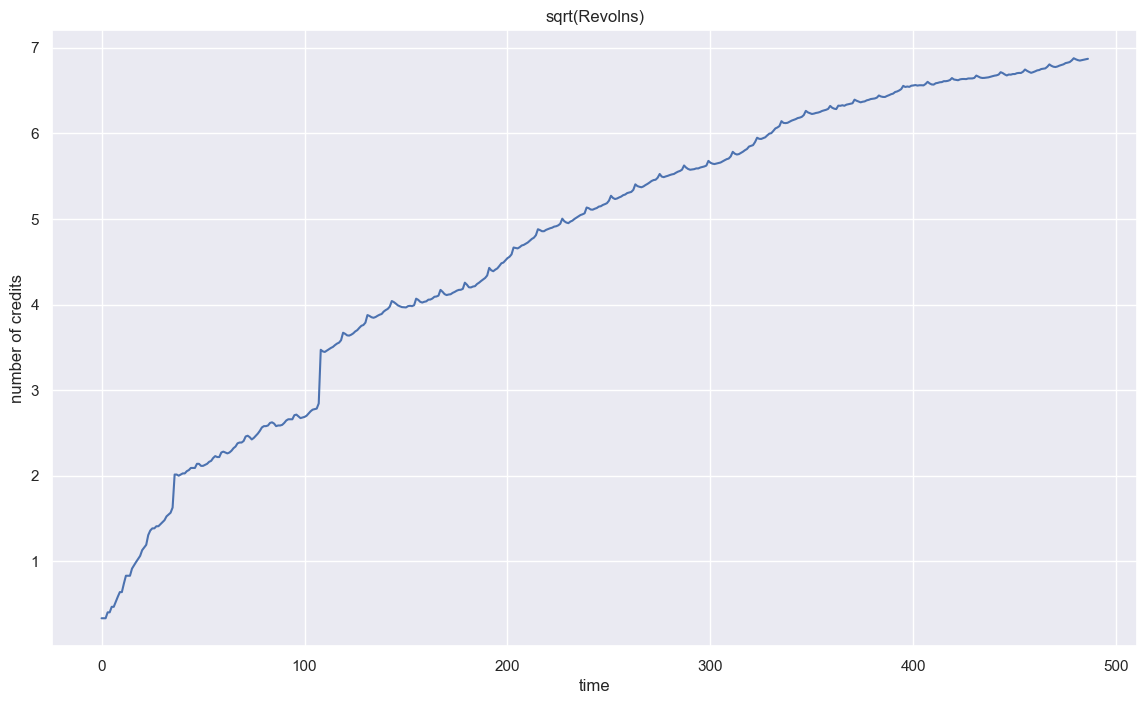

In [55]:
sns.lineplot(np.log(Revolns.squeeze())).set(title='sqrt(Revolns)', xlabel='time', ylabel='number of credits')

Тут також краще взяти корінь і ми майже позбулися тренду, я б сказав, що це лінійний тренд

## Поділимо дані

In [56]:
revolns_sqrt = np.sqrt(Revolns.squeeze())

revolns_sqrt_df = pd.DataFrame({'a_0': np.ones(len(revolns_sqrt)),
                                'k' : revolns_sqrt.index.values})

X_revolns_train, X_revolns_test, y_revolns_train, y_revolns_test = train_test_split(revolns_sqrt_df,
                                                                                    revolns_sqrt, test_size=0.1, shuffle=False)

## Модель у вигляді тренду

In [57]:
mls_trend = MLS()

mls_trend.fit(X_revolns_train, y_revolns_train)

predicted = mls_trend.predict(X_revolns_test)

results_2 = add_results(results_2, y_revolns_test, predicted)

trend_pred = predicted

print(f'coefs - {mls_trend.coefs} \n')
results_2

coefs - [array([-1.70764531,  0.06595691])] 



,S,R^2,IKA,DW,MSE,RMSE,MAE,MAPE,Theil-a
0,20.2422625288,0.9252070418,153.3808585365,0.0654399374,0.4131073985,0.6427343141,0.5914009491,2.0094653101,0.0000107337


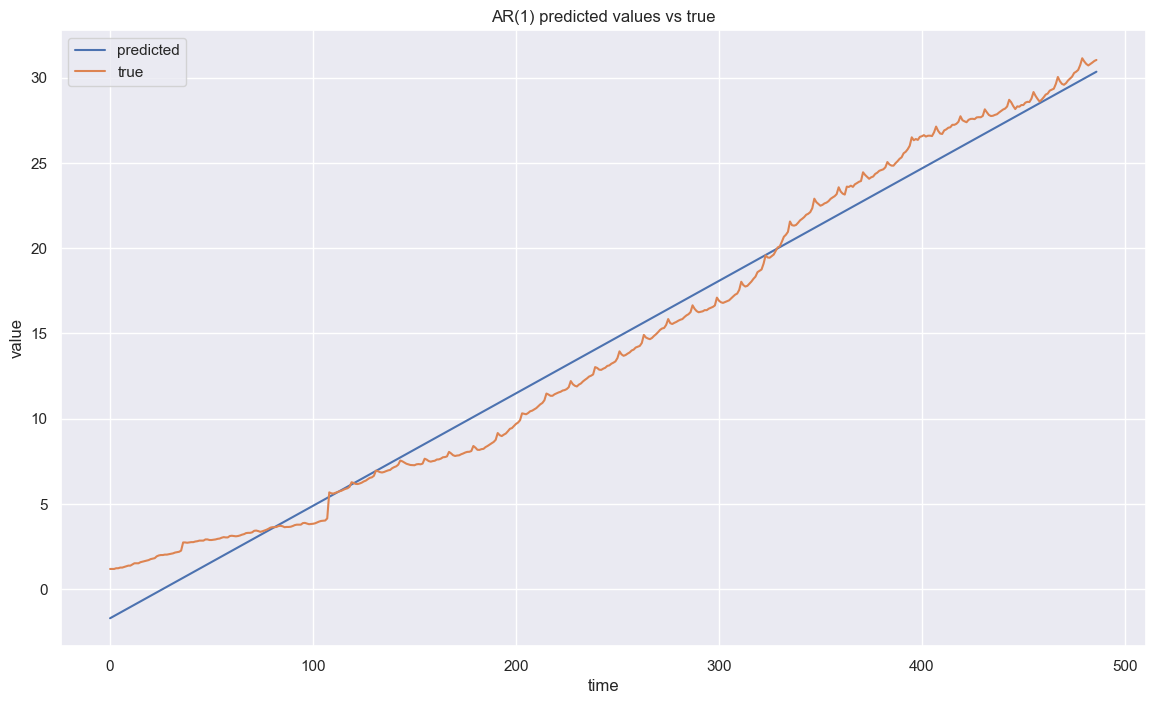

In [58]:
plt.plot(mls_trend.predict(revolns_sqrt_df), label='predicted')
plt.plot(revolns_sqrt, label='true')
plt.xlabel('time')
plt.ylabel('value')
plt.title('AR(1) predicted values vs true')
plt.legend()
plt.show()

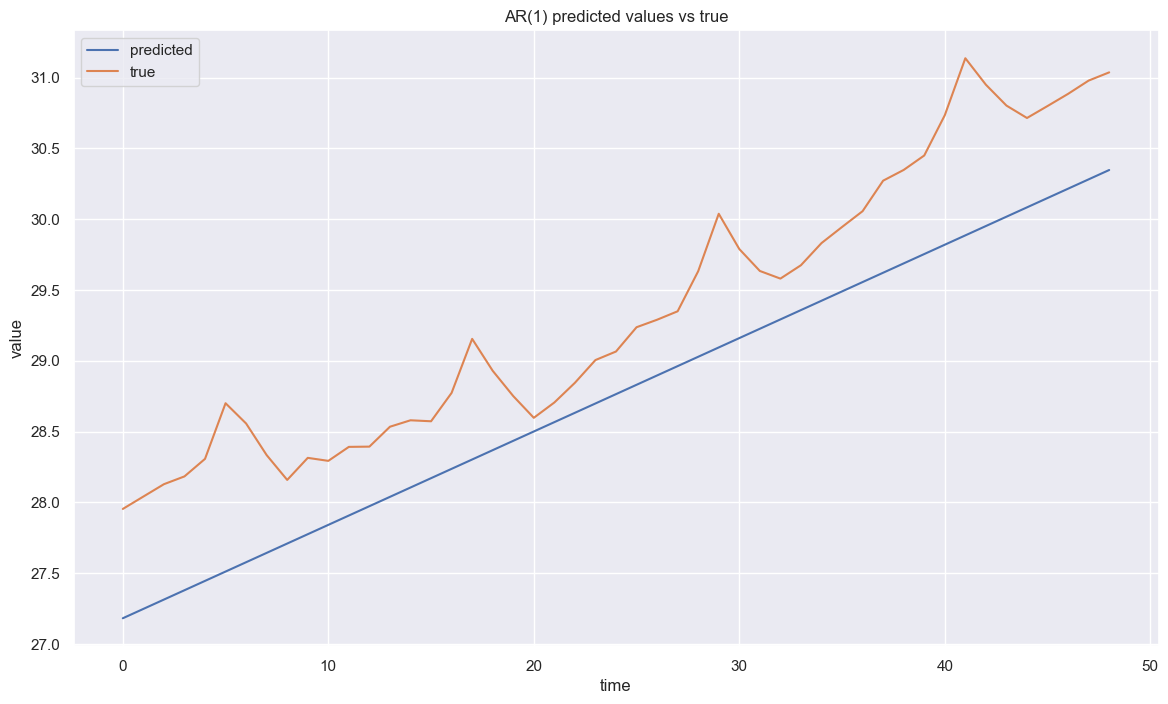

In [59]:
plt.plot(predicted, label='predicted')
plt.plot(y_revolns_test.values, label='true')
plt.xlabel('time')
plt.ylabel('value')
plt.title('AR(1) predicted values vs true')
plt.legend()
plt.show()

## ARIMA model

Підберемо d:

[Text(0.5, 1.0, 'sqrt(Revolns)'),
 Text(0.5, 0, 'time'),
 Text(0, 0.5, 'number of credits')]

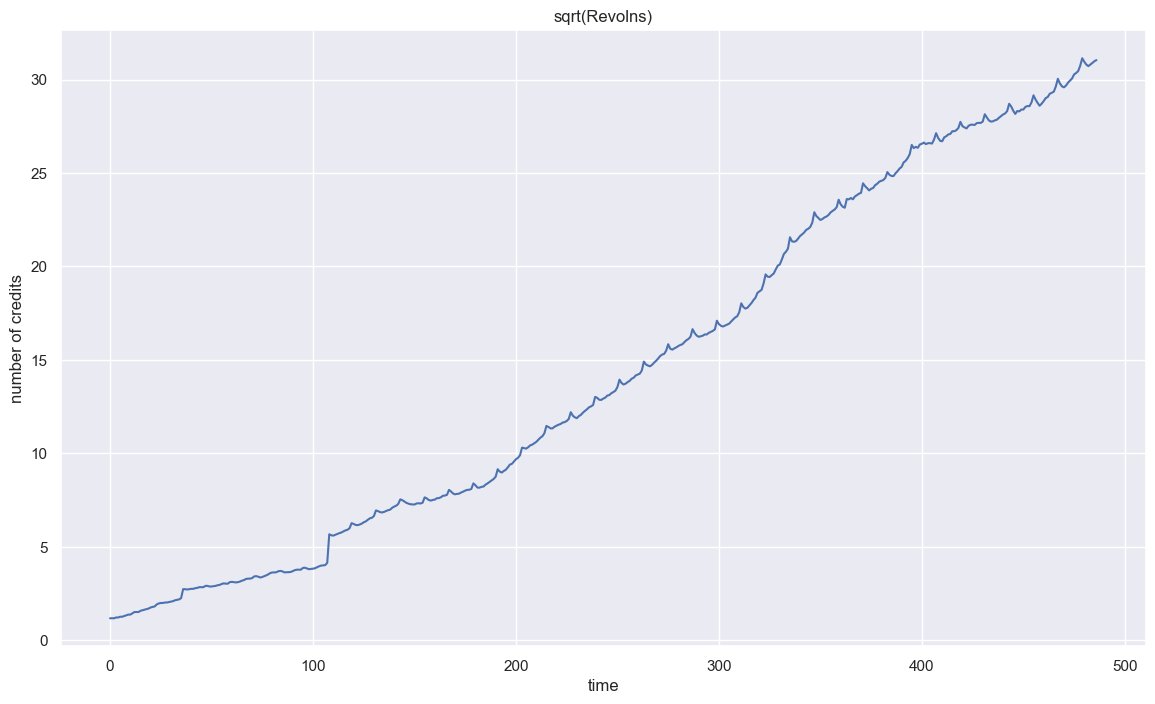

In [60]:
sns.lineplot(revolns_sqrt).set(title='sqrt(Revolns)', xlabel='time', ylabel='number of credits')

In [61]:
revolns_sqrt_diff = np.diff(revolns_sqrt, n=1)

[Text(0.5, 1.0, 'sqrt(Revolns), diff=1'),
 Text(0.5, 0, 'time'),
 Text(0, 0.5, 'number of credits')]

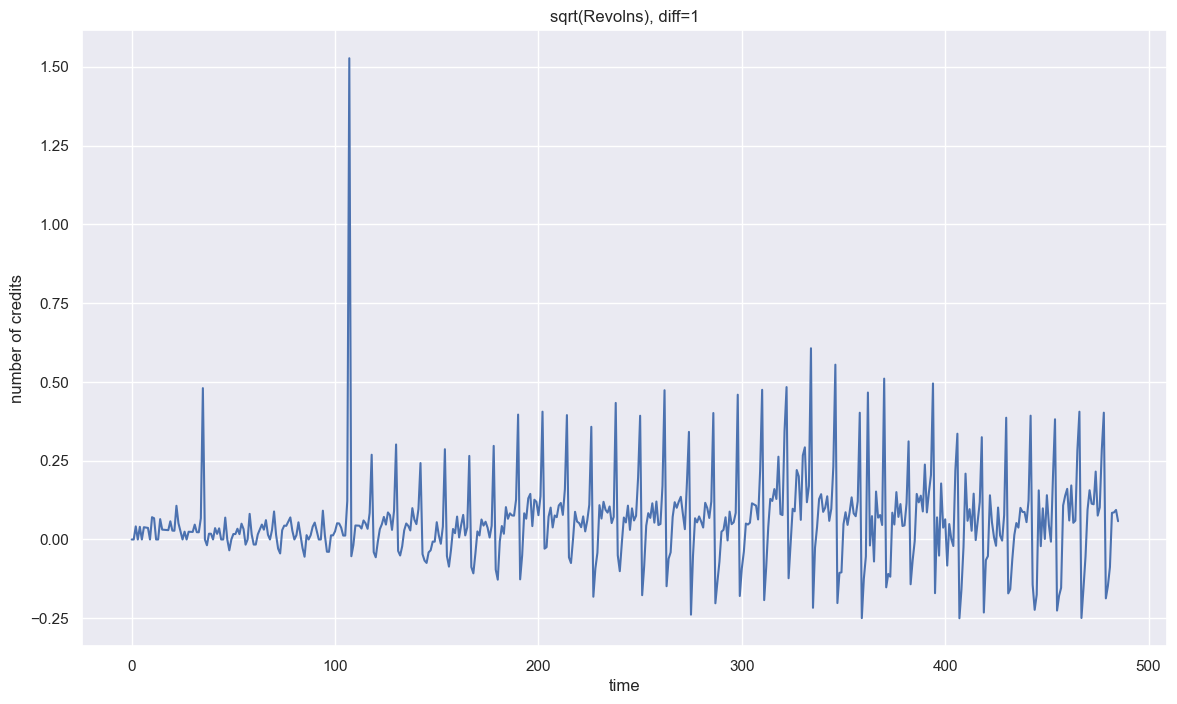

In [62]:
sns.lineplot(revolns_sqrt_diff).set(title='sqrt(Revolns), diff=1', xlabel='time', ylabel='number of credits')

### AR частина

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


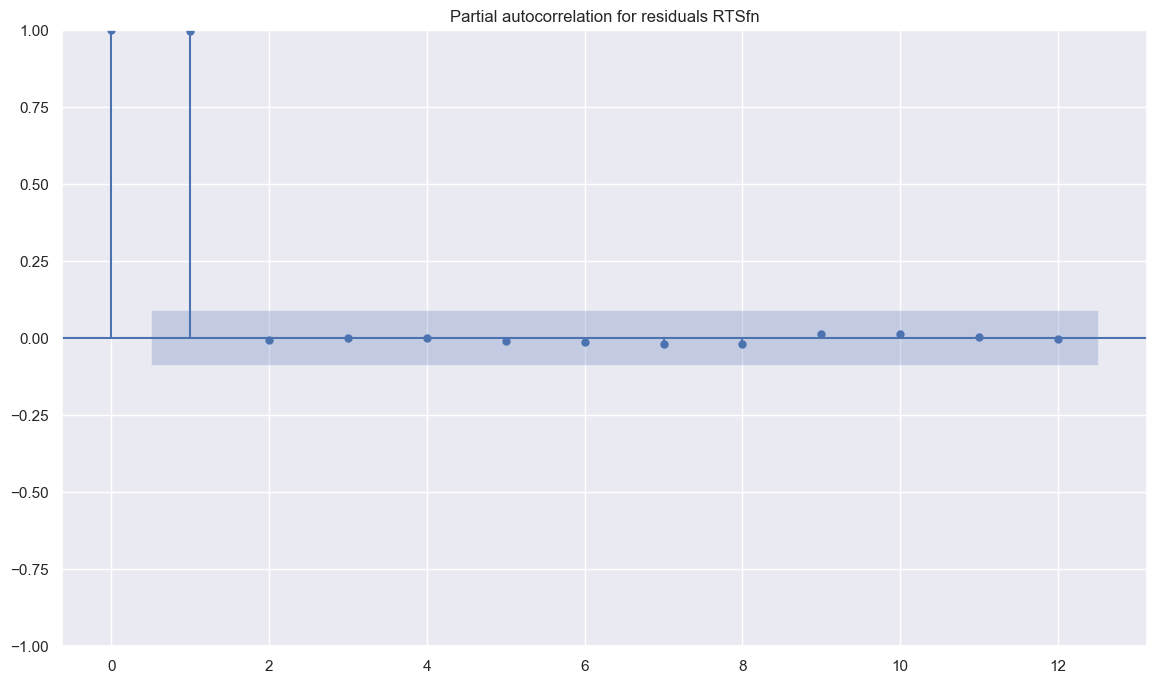

,autocorr
0,0.9946724722
1,0.9893156143
2,0.9839868894
3,0.9786874202
4,0.9733545031
5,0.9679657349
6,0.9624646799
7,0.9568691140
8,0.9513766274
9,0.9459874293


In [63]:
pacf = pd.DataFrame({'autocorr': acf(revolns_sqrt, nlags=12)[1:]})
                            # 'pacf': pacf(X_non_df_train, nlags=12)[1:]
plot_pacf(revolns_sqrt, lags=12, title='Partial autocorrelation for residuals RTSfn')
plt.show()
pacf

за p беремо 1

In [64]:
revolns_sqrt_diff_lagged = pd.DataFrame({'a_0' : np.ones(len(shift(revolns_sqrt_diff, 1, cval=0))),
                                       'y_k_1' : shift(revolns_sqrt_diff, 1, cval=0)})

X_revolns_train, X_revolns_test, y_revolns_train, y_revolns_test = train_test_split(revolns_sqrt_diff_lagged[1:],
                                                                                    revolns_sqrt_diff[1:], test_size=0.1, shuffle=False)

In [65]:
results_2 = add_results(results_2, y_revolns_test[1:], np.diff(np.sqrt(predicted.squeeze()), n=1))
results_2

,S,R^2,IKA,DW,MSE,RMSE,MAE,MAPE,Theil-a
0,20.2422625288,0.9252070418,153.3808585365,0.0654399374,0.4131073985,0.6427343141,0.5914009491,2.0094653101,0.0000107337
1,1.4865775141,0.0000003466,25.0308723577,1.4297507284,0.0309703649,0.1759839904,0.1455081769,102.7945065582,0.0000026324


### Навчання моделі

In [66]:
mls_revolns_diff = MLS()

mls_revolns_diff.fit(X_revolns_train, y_revolns_train)

predicted = mls_revolns_diff.predict(X_revolns_test)

resid = pd.Series(revolns_sqrt_diff[1:] - mls_revolns_diff.predict(revolns_sqrt_diff_lagged[1:]))

results_2 = add_results(results_2, y_revolns_test, predicted)

ari_pred = predicted

print(f'coefs - {mls_revolns_diff.coefs} \n')
results_2

coefs - [array([0.06015937, 0.01653955])] 



,S,R^2,IKA,DW,MSE,RMSE,MAE,MAPE,Theil-a
0,20.2422625288,0.9252070418,153.3808585365,0.0654399374,0.4131073985,0.6427343141,0.5914009491,2.0094653101,0.0000107337
1,1.4865775141,0.0000003466,25.0308723577,1.4297507284,0.0309703649,0.1759839904,0.1455081769,102.7945065582,0.0000026324
2,1.3181939455,0.0002736983,19.5368662534,1.6245863079,0.0269019173,0.1640180394,0.1243724732,164.7940011120,0.0000201635


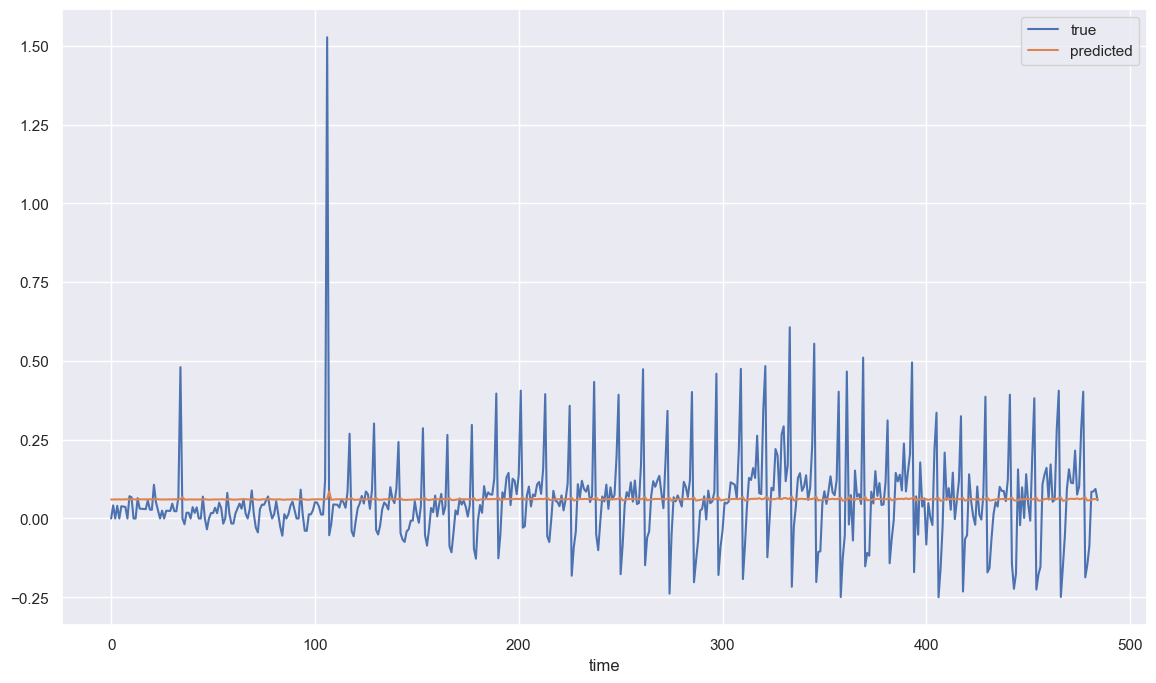

In [67]:
plt.plot(revolns_sqrt_diff[1:], label='true')
plt.plot(mls_revolns_diff.predict(revolns_sqrt_diff_lagged[1:]), label='predicted')
plt.xlabel('time')
plt.legend()

### MA частина

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


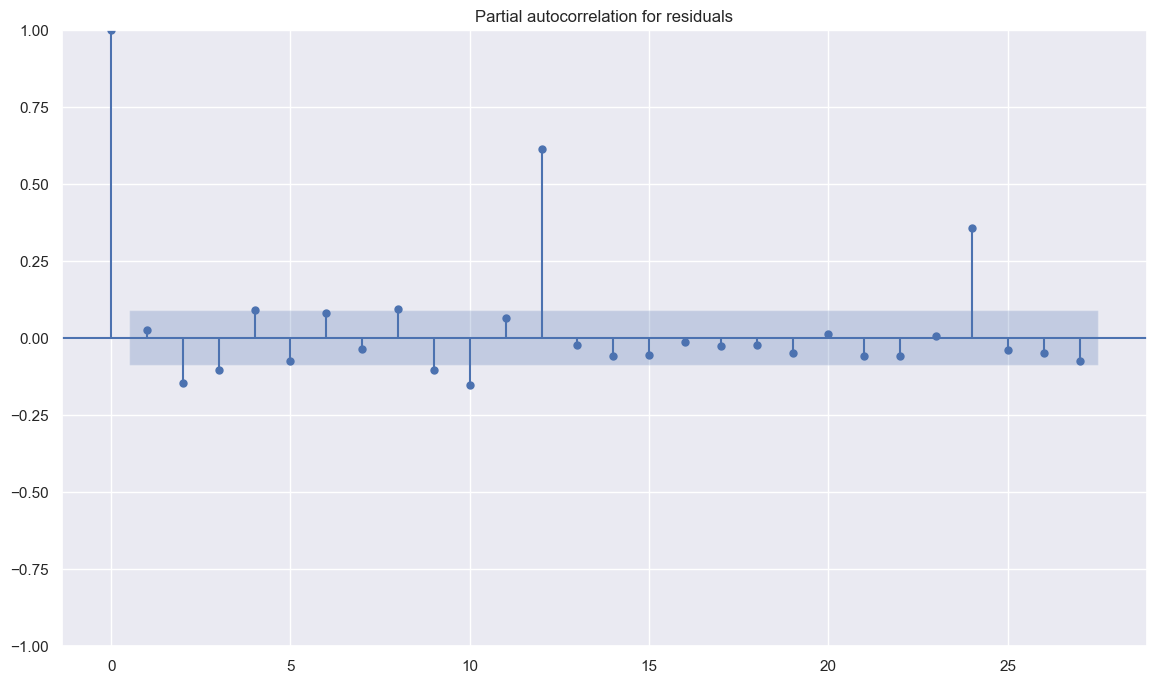

,autocorr
0,0.0255480037
1,-0.1452402042
2,-0.1094282306
3,0.1037353893
4,-0.0357777485
5,0.0582819499
6,-0.0362468055
7,0.0884102433
8,-0.1062113513
9,-0.1494955511


In [68]:
pacf_resid = pd.DataFrame({'autocorr': acf(resid, nlags=12)[1:]})
                            # 'pacf': pacf(resid, nlags=12)[1:]})
plot_pacf(resid, title='Partial autocorrelation for residuals')
plt.show()
pacf_resid

Додамо 12 лаг

In [69]:
ema_5 = calculate_ema(resid, 5)

ema_5_12 = shift(ema_5, 12, cval=0)


revolns_sqrt_diff_lagged_arima = pd.DataFrame({'a_0' : np.ones(len(shift(revolns_sqrt_diff, 1, cval=0)))[1:],
                                       'y_k_1' : shift(revolns_sqrt_diff, 1, cval=0)[1:],
                                       'ema_5_12' : ema_5_12})

X_revolns_train_arima, X_revolns_test_arima, y_revolns_train_arima, y_revolns_test_arima = train_test_split(revolns_sqrt_diff_lagged_arima[16:],
                                                                                    revolns_sqrt_diff[17:], test_size=0.1, shuffle=False)

In [70]:
mls_arima = MLS()

mls_arima.fit(X_revolns_train_arima, y_revolns_train_arima)

predicted = mls_arima.predict(X_revolns_test_arima)

resid = pd.Series(revolns_sqrt_diff[17:] - mls_arima.predict(revolns_sqrt_diff_lagged_arima[16:]))

arima_pred = predicted

results_2 = add_results(results_2, y_revolns_test_arima, predicted)

print(f'coefs - {mls_arima.coefs} \n')
results_2

coefs - [array([ 0.06817022, -0.11139948,  1.05698295])] 



,S,R^2,IKA,DW,MSE,RMSE,MAE,MAPE,Theil-a
0,20.2422625288,0.9252070418,153.3808585365,0.0654399374,0.4131073985,0.6427343141,0.5914009491,2.0094653101,0.0000107337
1,1.4865775141,0.0000003466,25.0308723577,1.4297507284,0.0309703649,0.1759839904,0.1455081769,102.7945065582,0.0000026324
2,1.3181939455,0.0002736983,19.5368662534,1.6245863079,0.0269019173,0.1640180394,0.1243724732,164.7940011120,0.0000201635
3,0.8066299239,0.1110921160,-4.0998440236,1.5423395168,0.0171623388,0.1310051099,0.1071133027,132.2921281113,0.0128082204


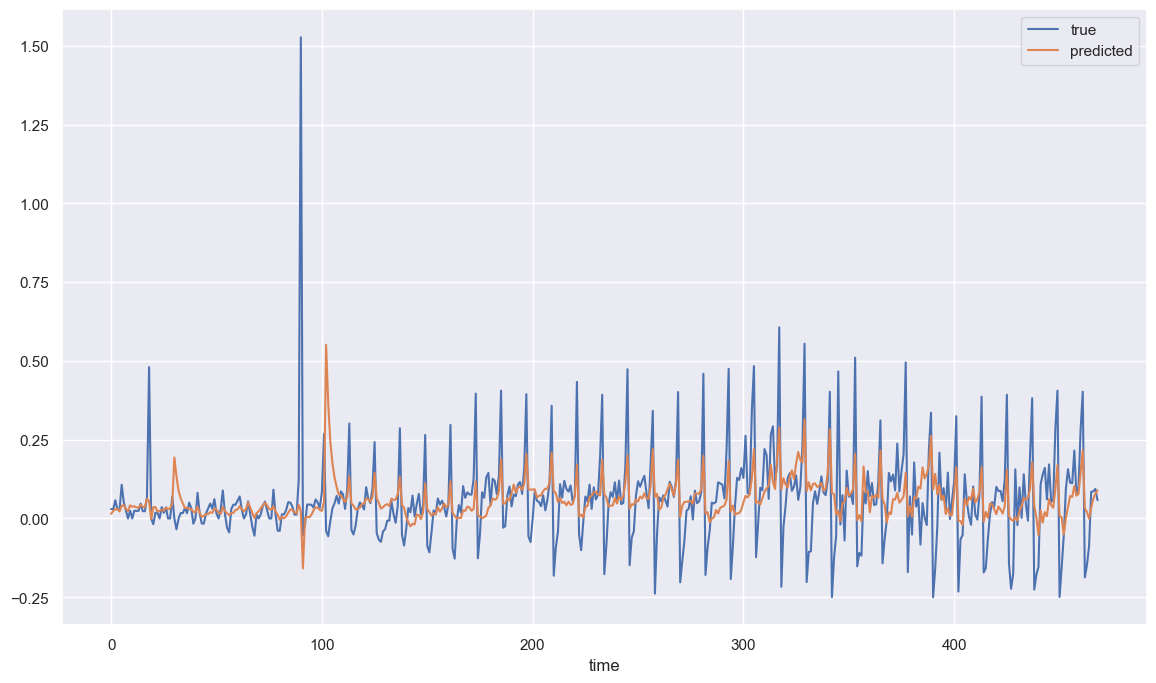

In [71]:
plt.plot(revolns_sqrt_diff[17:], label='true')
plt.plot(mls_arima.predict(revolns_sqrt_diff_lagged_arima[16:]), label='predicted')
plt.xlabel('time')
plt.legend()

### Dynamic predictions for ARIMA

In [72]:
rls_model = RLS(n_features=X_revolns_train_arima.shape[1])

rls_model.fit(X_revolns_train_arima.values, y_revolns_train_arima)

predicted = dynamic_predict_rls(rls_model, X_revolns_test_arima.values)

results_2 = add_results(results_2, y_revolns_test_arima, predicted)

arima_dyn_pred = predicted

print(f'coefs - {rls_model.weights} \n')
results_2

coefs - [[ 0.0630299 ]
 [-0.01945817]
 [ 0.6666156 ]] 



,S,R^2,IKA,DW,MSE,RMSE,MAE,MAPE,Theil-a
0,20.2422625288,0.9252070418,153.3808585365,0.0654399374,0.4131073985,0.6427343141,0.5914009491,2.0094653101,0.0000107337
1,1.4865775141,0.0000003466,25.0308723577,1.4297507284,0.0309703649,0.1759839904,0.1455081769,102.7945065582,0.0000026324
2,1.3181939455,0.0002736983,19.5368662534,1.6245863079,0.0269019173,0.1640180394,0.1243724732,164.7940011120,0.0000201635
3,0.8066299239,0.1110921160,-4.0998440236,1.5423395168,0.0171623388,0.1310051099,0.1071133027,132.2921281113,0.0128082204
4,0.9500278640,0.0559816701,3.5905936789,1.6627877699,0.0202133588,0.1421736924,0.1136402751,148.0668925587,0.0057890246


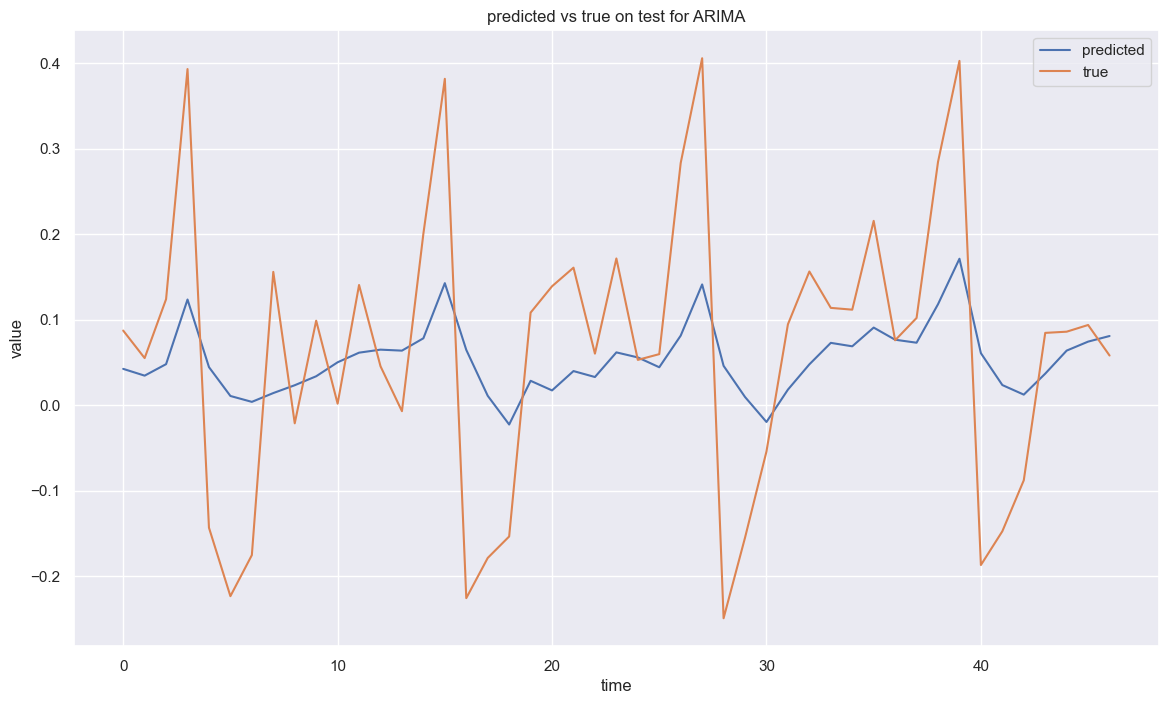

In [73]:
plt.plot(predicted, label='predicted')
plt.plot(y_revolns_test_arima, label='true')
plt.xlabel('time')
plt.ylabel('value')
plt.title('predicted vs true on test for ARIMA')
plt.legend()
plt.show()

## AR:

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


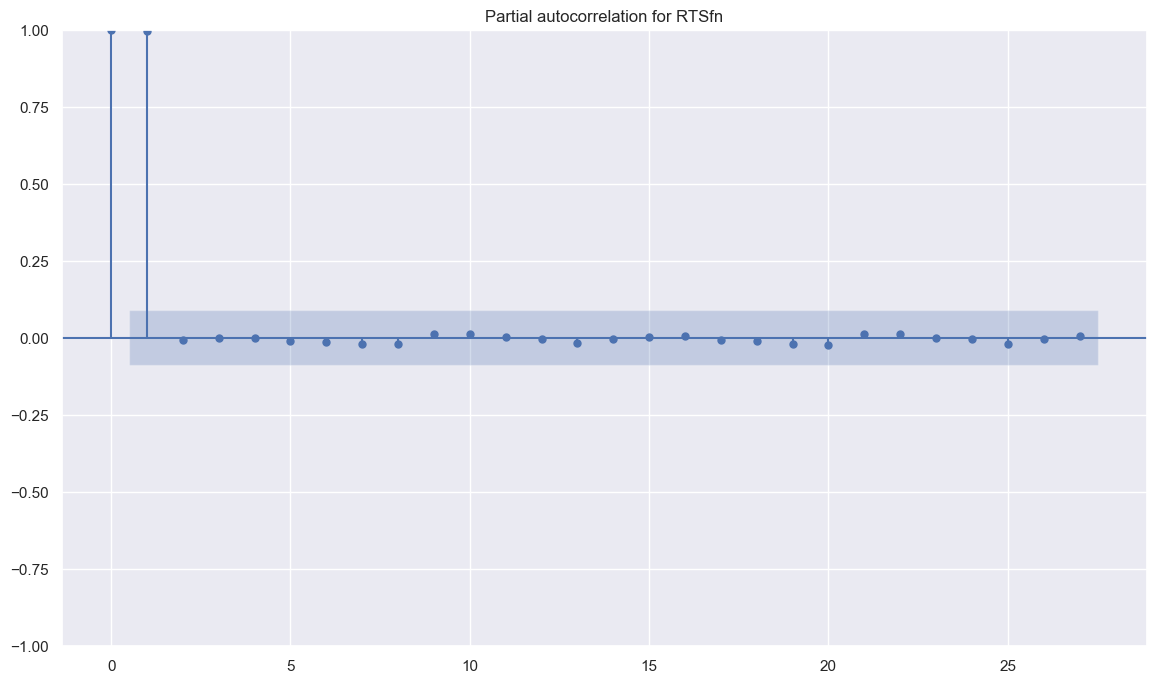

,autocorr
0,0.9946724722
1,0.9893156143
2,0.9839868894
3,0.9786874202
4,0.9733545031
5,0.9679657349
6,0.9624646799
7,0.9568691140
8,0.9513766274
9,0.9459874293


In [74]:
pacf_revolns_sqrt = pd.DataFrame({'autocorr': acf(revolns_sqrt, nlags=12)[1:]})
                            # 'pacf': pacf(non_df_sqrt, nlags=12)[1:]})
plot_pacf(revolns_sqrt, title='Partial autocorrelation for RTSfn')
plt.show()

pacf_revolns_sqrt

Очевидно, що p = 1 

In [75]:
revolns_sqrt_lagged = pd.DataFrame({'a_0' : np.ones(len(shift(revolns_sqrt, 1, cval=0))),
                                       'y_k_1' : shift(revolns_sqrt, 1, cval=0)})

X_revolns_sqrt_train_ar, X_revolns_sqrt_test_ar, y_revolns_sqrt_train_ar, y_revolns_sqrt_test_ar = train_test_split(revolns_sqrt_lagged[1:],
                                                                                                                    revolns_sqrt[1:], test_size=0.1, shuffle=False)

### Статичні

In [76]:
mls_revolns_ar = MLS()

mls_revolns_ar.fit(X_revolns_sqrt_train_ar, y_revolns_sqrt_train_ar)

predicted = mls_revolns_ar.predict(X_revolns_sqrt_test_ar)

resid = pd.Series(revolns_sqrt[1:] - mls_revolns_ar.predict(revolns_sqrt_lagged[1:]))

results_2 = add_results(results_2, y_revolns_sqrt_test_ar, predicted)

ar_pred = predicted

print(f'coefs - {mls_revolns_ar.coefs} \n')
results_2

coefs - [array([0.04304275, 1.00141973])] 



,S,R^2,IKA,DW,MSE,RMSE,MAE,MAPE,Theil-a
0,20.2422625288,0.9252070418,153.3808585365,0.0654399374,0.4131073985,0.6427343141,0.5914009491,2.0094653101,0.0000107337
1,1.4865775141,0.0000003466,25.0308723577,1.4297507284,0.0309703649,0.1759839904,0.1455081769,102.7945065582,0.0000026324
2,1.3181939455,0.0002736983,19.5368662534,1.6245863079,0.0269019173,0.1640180394,0.1243724732,164.7940011120,0.0000201635
3,0.8066299239,0.1110921160,-4.0998440236,1.5423395168,0.0171623388,0.1310051099,0.1071133027,132.2921281113,0.0128082204
4,0.9500278640,0.0559816701,3.5905936789,1.6627877699,0.0202133588,0.1421736924,0.1136402751,148.0668925587,0.0057890246
5,1.3455817210,0.9859657524,20.5444948678,1.5819410064,0.0274608514,0.1657131602,0.1217574709,0.4142121693,0.0000109181


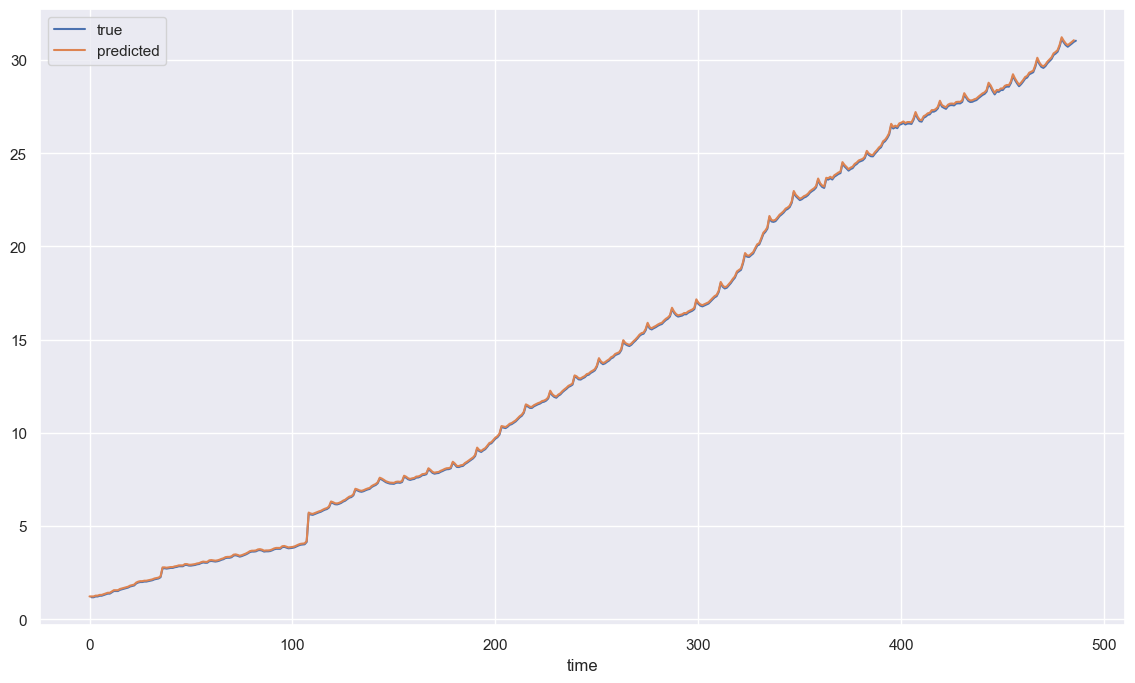

In [77]:
plt.plot(revolns_sqrt[1:], label='true')
plt.plot(mls_revolns_ar.predict(revolns_sqrt_lagged[1:]), label='predicted')
plt.xlabel('time')
plt.legend()

### Динамічні для AR

In [78]:
rls_model = RLS(n_features=X_revolns_sqrt_train_ar.shape[1])

rls_model.fit(X_revolns_sqrt_train_ar.values, y_revolns_sqrt_train_ar.values)

predicted = dynamic_predict_rls(rls_model, X_revolns_sqrt_test_ar.values)

results_2 = add_results(results_2, y_revolns_sqrt_test_ar, predicted)

ar_dyn_pred = predicted

print(f'coefs - {rls_model.weights} \n')
results_2

coefs - [[0.04935366]
 [1.00107046]] 



,S,R^2,IKA,DW,MSE,RMSE,MAE,MAPE,Theil-a
0,20.2422625288,0.9252070418,153.3808585365,0.0654399374,0.4131073985,0.6427343141,0.5914009491,2.0094653101,0.0000107337
1,1.4865775141,0.0000003466,25.0308723577,1.4297507284,0.0309703649,0.1759839904,0.1455081769,102.7945065582,0.0000026324
2,1.3181939455,0.0002736983,19.5368662534,1.6245863079,0.0269019173,0.1640180394,0.1243724732,164.7940011120,0.0000201635
3,0.8066299239,0.1110921160,-4.0998440236,1.5423395168,0.0171623388,0.1310051099,0.1071133027,132.2921281113,0.0128082204
4,0.9500278640,0.0559816701,3.5905936789,1.6627877699,0.0202133588,0.1421736924,0.1136402751,148.0668925587,0.0057890246
5,1.3455817210,0.9859657524,20.5444948678,1.5819410064,0.0274608514,0.1657131602,0.1217574709,0.4142121693,0.0000109181
6,1.3385551131,0.9852781235,20.2879471621,1.5896878766,0.0273174513,0.1652799180,0.1220205843,0.4150892599,0.0000109134


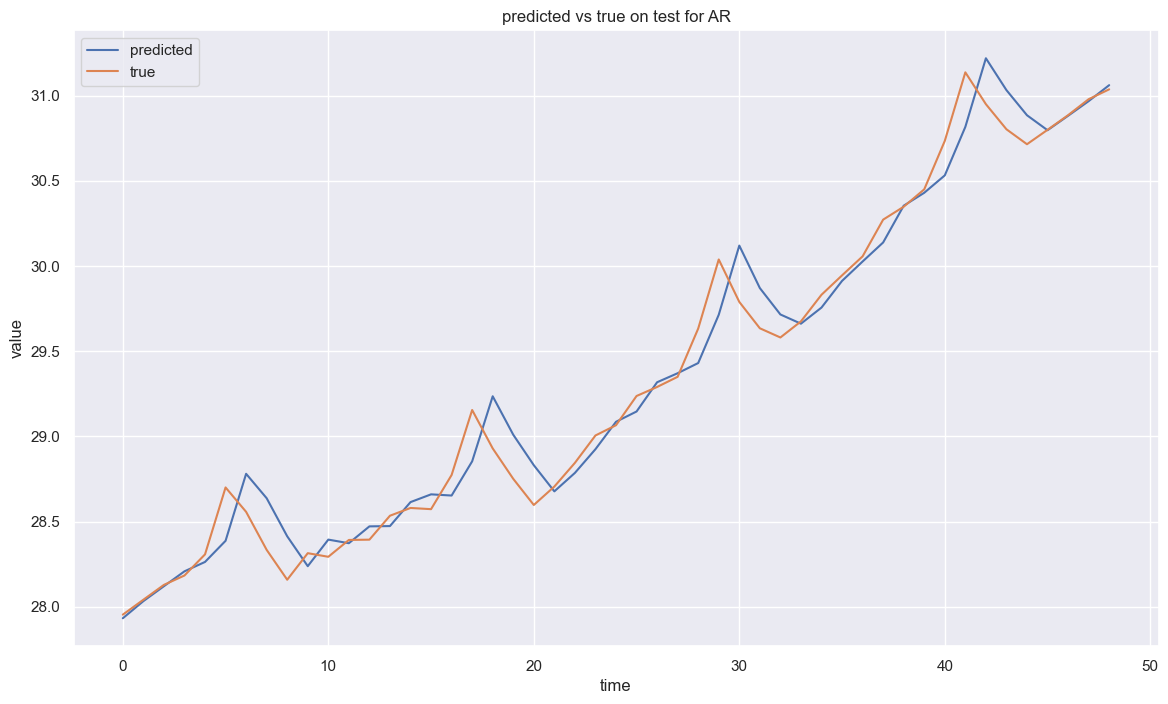

In [79]:
plt.plot(predicted, label='predicted')
plt.plot(y_revolns_sqrt_test_ar.values, label='true')
plt.xlabel('time')
plt.ylabel('value')
plt.title('predicted vs true on test for AR')
plt.legend()
plt.show()

## ARMA, цю модель будемо будувати по вихідному сигналу

Використовувати будемо ema з вікном у 5, як і минулого разу

In [80]:
ema_5 = calculate_ema(resid.values, 5)

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


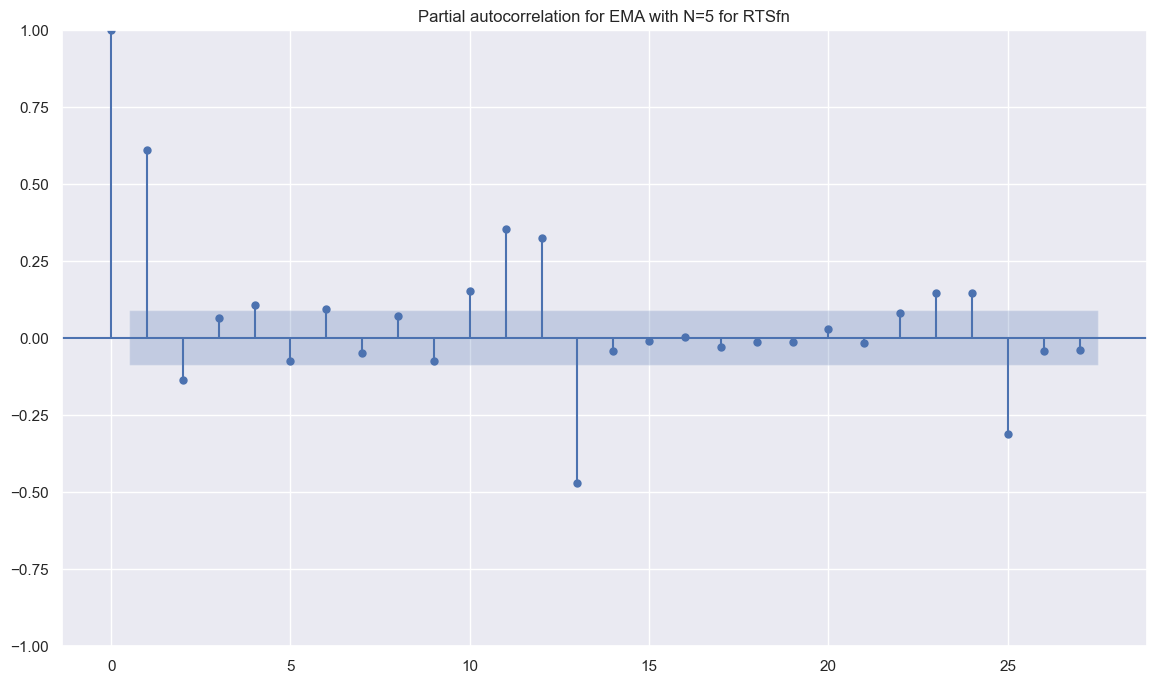

,autocorr
0,0.6082256687
1,0.2851947264
2,0.1549093110
3,0.1606955475
4,0.1018289764
5,0.0975877048
6,0.0624629990
7,0.0779215938
8,0.0280867412
9,0.0891346995


In [81]:
pacf = pd.DataFrame({'autocorr': acf(ema_5[4:], nlags=12)[1:]})
                    #  'pacf': pacf(ema_5[4:], nlags=12)[1:]}) 
                    # error - 'DataFrame' object is not callable
plot_pacf(ema_5[4:], title='Partial autocorrelation for EMA with N=5 for RTSfn')
plt.show()

pacf

q = 1, 11, 12, 13

In [82]:
revolns_sqrt_lagged_arma = pd.DataFrame({'a_0' : np.ones(len(ema_5)),
                                       'y_k_1' : shift(revolns_sqrt, 1, cval=0)[1:],
                                       'ema_5_1': shift(ema_5, 1, cval=0),
                                       'ema_5_11': shift(ema_5, 11, cval=0), 'ema_5_12': shift(ema_5, 12, cval=0),
                                       'ema_5_13': shift(ema_5, 13, cval=0)})

X_revolns_sqrt_train_arma, X_revolns_sqrt_test_arma, \
y_revolns_sqrt_train_arma, y_revolns_sqrt_test_arma = train_test_split(revolns_sqrt_lagged_arma[17:],
                                                                       revolns_sqrt[18:], test_size=0.1, shuffle=False)

In [83]:
mls_revolns_arma = MLS()

mls_revolns_arma.fit(X_revolns_sqrt_train_arma, y_revolns_sqrt_train_arma)

predicted = mls_revolns_arma.predict(X_revolns_sqrt_test_arma)

resid = pd.Series(revolns_sqrt[18:] - mls_revolns_arma.predict(revolns_sqrt_lagged_arma[17:]))

results_2 = add_results(results_2, y_revolns_sqrt_test_arma, predicted)

arma_pred = predicted

print(f'coefs - {mls_revolns_arma.coefs} \n')
results_2

coefs - [array([ 0.04671375,  1.00114276,  0.01925159,  0.01981392,  1.79441018,
       -1.40207217])] 



,S,R^2,IKA,DW,MSE,RMSE,MAE,MAPE,Theil-a
0,20.2422625288,0.9252070418,153.3808585365,0.0654399374,0.4131073985,0.6427343141,0.5914009491,2.0094653101,0.0000107337
1,1.4865775141,0.0000003466,25.0308723577,1.4297507284,0.0309703649,0.1759839904,0.1455081769,102.7945065582,0.0000026324
2,1.3181939455,0.0002736983,19.5368662534,1.6245863079,0.0269019173,0.1640180394,0.1243724732,164.7940011120,0.0000201635
3,0.8066299239,0.1110921160,-4.0998440236,1.5423395168,0.0171623388,0.1310051099,0.1071133027,132.2921281113,0.0128082204
4,0.9500278640,0.0559816701,3.5905936789,1.6627877699,0.0202133588,0.1421736924,0.1136402751,148.0668925587,0.0057890246
5,1.3455817210,0.9859657524,20.5444948678,1.5819410064,0.0274608514,0.1657131602,0.1217574709,0.4142121693,0.0000109181
6,1.3385551131,0.9852781235,20.2879471621,1.5896878766,0.0273174513,0.1652799180,0.1220205843,0.4150892599,0.0000109134
7,0.3224628288,0.9861849534,-47.1930682247,1.6599820904,0.0068609113,0.0828306178,0.0694018276,0.2370987233,0.0000108486


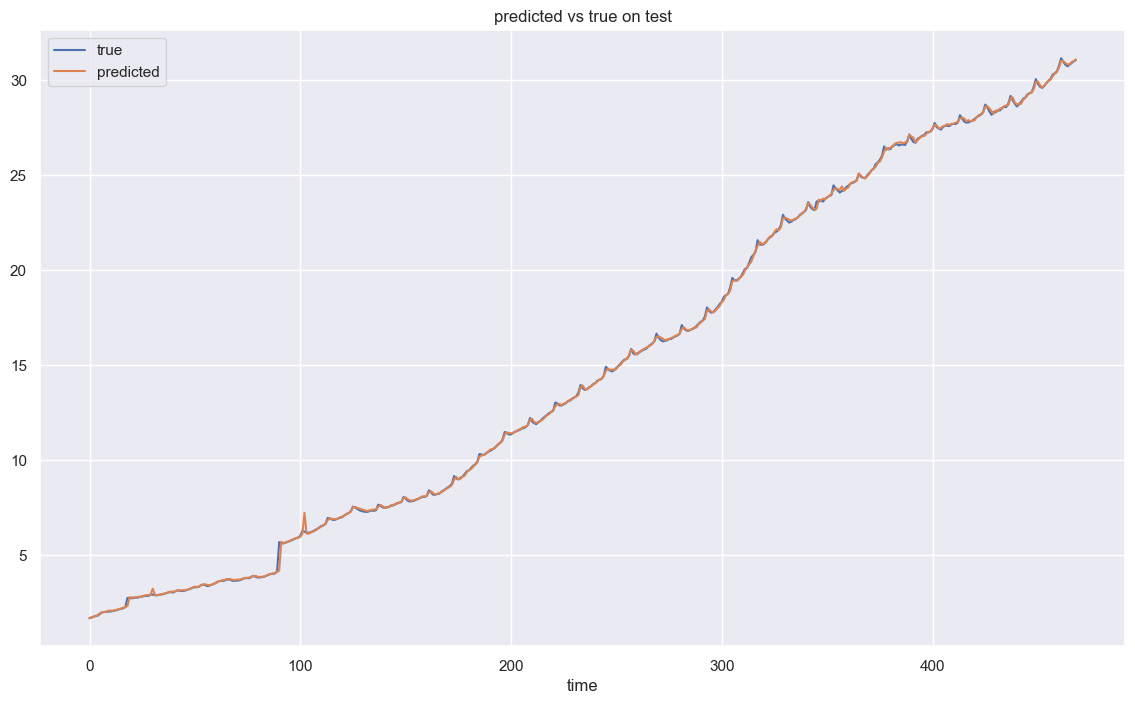

In [84]:
plt.plot(revolns_sqrt[18:].reset_index(drop=True), label='true')
plt.plot(mls_revolns_arma.predict(revolns_sqrt_lagged_arma[17:]), label='predicted')
plt.xlabel('time')
plt.title('predicted vs true on test')
plt.legend()

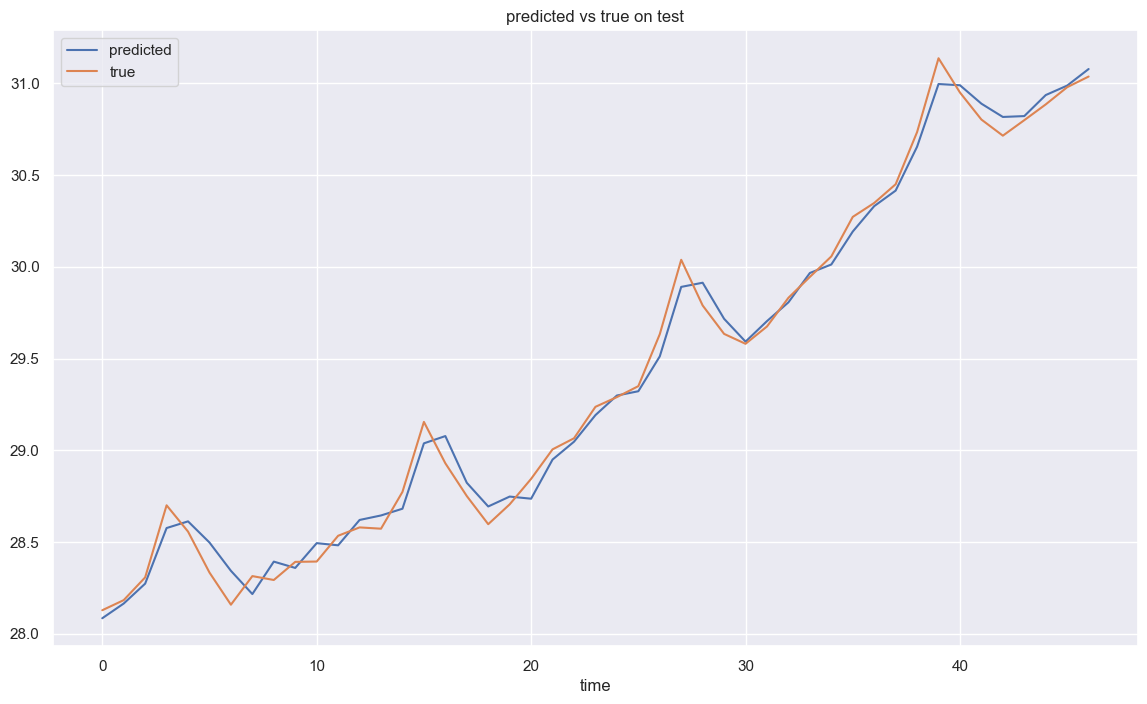

In [85]:
plt.plot(predicted, label='predicted')
plt.plot(y_revolns_sqrt_test_arma.values, label='true')
plt.xlabel('time')
plt.title('predicted vs true on test')
plt.legend()
plt.show()

### Dynamic predictions for ARMA

In [86]:
rls_model = RLS(n_features=X_revolns_sqrt_train_arma.shape[1])

rls_model.fit(X_revolns_sqrt_train_arma.values, y_revolns_sqrt_train_arma.values)

predicted = dynamic_predict_rls(rls_model, X_revolns_sqrt_test_arma.values)

results_2 = add_results(results_2, y_revolns_sqrt_test_arma, predicted)

arma_dyn_pred = predicted

print(f'coefs - {rls_model.weights} \n')
results_2

coefs - [[ 0.05773457]
 [ 1.00034547]
 [ 0.09222094]
 [ 0.42516162]
 [ 0.91619339]
 [-0.34383949]] 



,S,R^2,IKA,DW,MSE,RMSE,MAE,MAPE,Theil-a
0,20.2422625288,0.9252070418,153.3808585365,0.0654399374,0.4131073985,0.6427343141,0.5914009491,2.0094653101,0.0000107337
1,1.4865775141,0.0000003466,25.0308723577,1.4297507284,0.0309703649,0.1759839904,0.1455081769,102.7945065582,0.0000026324
2,1.3181939455,0.0002736983,19.5368662534,1.6245863079,0.0269019173,0.1640180394,0.1243724732,164.7940011120,0.0000201635
3,0.8066299239,0.1110921160,-4.0998440236,1.5423395168,0.0171623388,0.1310051099,0.1071133027,132.2921281113,0.0128082204
4,0.9500278640,0.0559816701,3.5905936789,1.6627877699,0.0202133588,0.1421736924,0.1136402751,148.0668925587,0.0057890246
5,1.3455817210,0.9859657524,20.5444948678,1.5819410064,0.0274608514,0.1657131602,0.1217574709,0.4142121693,0.0000109181
6,1.3385551131,0.9852781235,20.2879471621,1.5896878766,0.0273174513,0.1652799180,0.1220205843,0.4150892599,0.0000109134
7,0.3224628288,0.9861849534,-47.1930682247,1.6599820904,0.0068609113,0.0828306178,0.0694018276,0.2370987233,0.0000108486
8,0.6544690544,1.0116465006,-13.9247558702,1.8311046990,0.0139248735,0.1180037012,0.0959249583,0.3269244548,0.0000111539


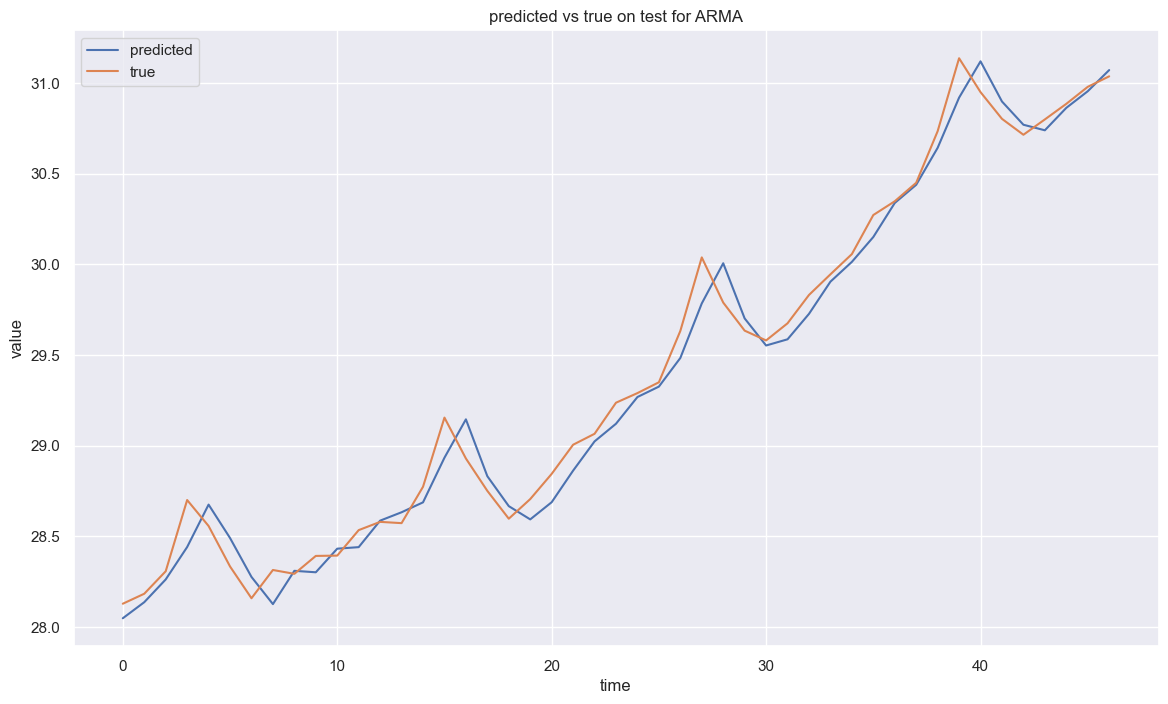

In [87]:
plt.plot(predicted, label='predicted')
plt.plot(y_revolns_sqrt_test_arma.values, label='true')
plt.xlabel('time')
plt.ylabel('value')
plt.title('predicted vs true on test for ARMA')
plt.legend()
plt.show()

# Revolns results

In [88]:
revolns_sqrt = np.sqrt(Revolns.squeeze())

y_revolns_train, y_revolns_test = train_test_split(revolns_sqrt, test_size=0.1, shuffle=False)

In [89]:
pd.DataFrame({'Реальне значення sqrt y': y_revolns_test[2:],
              'Тренд 1-го порядку': trend_pred[2:],
              'АРІКС (1, 1, 1)': arima_pred,
              'АР(1)': ar_pred[2:],
              'АРКС(1, 4)': arma_pred}).head()

C:\Users\Kidma\AppData\Local\Temp\ipykernel_27784\1628453615.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  pd.DataFrame({'Реальне значення sqrt y': y_revolns_test[2:],


,Реальне значення sqrt y,Тренд 1-го порядку,"АРІКС (1, 1, 1)",АР(1),"АРКС(1, 4)"
440,28.1282775868,27.3133936194,0.0285103270,28.1238947739,28.0845896622
441,28.1833284053,27.3793505261,0.0159687154,28.2112548623,28.1648100523
442,28.3072428894,27.4453074327,0.0398719885,28.2663838381,28.2731835759
443,28.7001742155,27.5112643394,0.1540943885,28.3904742471,28.5762336080
444,28.5569606226,27.5772212460,0.0071553581,28.7839634291,28.6126517590


In [90]:
pd.DataFrame({'Реальне значення sqrt y': y_revolns_test[2:],
              'АРІКС (1, 1, 1) динамічний': arima_dyn_pred,
              'АР(1), динамічний': ar_dyn_pred[2:],
              'АРКС(1, 4), динамічний': arma_dyn_pred}).head()

C:\Users\Kidma\AppData\Local\Temp\ipykernel_27784\2737384167.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  pd.DataFrame({'Реальне значення sqrt y': y_revolns_test[2:],


,Реальне значення sqrt y,"АРІКС (1, 1, 1) динамічний","АР(1), динамічний","АРКС(1, 4), динамічний"
440,28.1282775868,0.0424626312,28.1204119513,28.0481329406
441,28.1833284053,0.0345390865,28.2077415713,28.1367048508
442,28.3072428894,0.0479793612,28.2628513197,28.2620702850
443,28.7001742155,0.1235150900,28.3868984499,28.4409019123
444,28.5569606226,0.0445097046,28.7802503950,28.6749166658


In [91]:
results_2.set_index(pd.Index(idx)).T

,Тренд,тренд у скейлі,"АРІ(4, 2)","АРІКС(4, 2, 3)","АРІКС(4, 2, 3) динам",АР(1),АР(1) динамічний,"АРКС(1, 1)","АРКС(1, 1) динамічний"
S,20.2422625288,1.4865775141,1.3181939455,0.8066299239,0.9500278640,1.3455817210,1.3385551131,0.3224628288,0.6544690544
R^2,0.9252070418,0.0000003466,0.0002736983,0.1110921160,0.0559816701,0.9859657524,0.9852781235,0.9861849534,1.0116465006
IKA,153.3808585365,25.0308723577,19.5368662534,-4.0998440236,3.5905936789,20.5444948678,20.2879471621,-47.1930682247,-13.9247558702
DW,0.0654399374,1.4297507284,1.6245863079,1.5423395168,1.6627877699,1.5819410064,1.5896878766,1.6599820904,1.8311046990
MSE,0.4131073985,0.0309703649,0.0269019173,0.0171623388,0.0202133588,0.0274608514,0.0273174513,0.0068609113,0.0139248735
RMSE,0.6427343141,0.1759839904,0.1640180394,0.1310051099,0.1421736924,0.1657131602,0.1652799180,0.0828306178,0.1180037012
MAE,0.5914009491,0.1455081769,0.1243724732,0.1071133027,0.1136402751,0.1217574709,0.1220205843,0.0694018276,0.0959249583
MAPE,2.0094653101,102.7945065582,164.7940011120,132.2921281113,148.0668925587,0.4142121693,0.4150892599,0.2370987233,0.3269244548
Theil-a,0.0000107337,0.0000026324,0.0000201635,0.0128082204,0.0057890246,0.0000109181,0.0000109134,0.0000108486,0.0000111539


In [92]:
idx = ['Тренд', 'Тренд у скейлі', 'АРІ(1, 1)', 'АРІКС(1, 1, 1)', 'АРІКС(1, 1, 1) динам',
       'АР(1)', 'АР(1) динамічний', 'АРКС(1, 4)', 'АРКС(1, 4) динамічний']

results_2.set_index(pd.Index(idx)).loc[['Тренд', 'АРІ(1, 1)', 'АРІКС(1, 1, 1)', 'АР(1)', 'АРКС(1, 4)']].T

,Тренд,"АРІ(1, 1)","АРІКС(1, 1, 1)",АР(1),"АРКС(1, 4)"
S,20.2422625288,1.3181939455,0.8066299239,1.3455817210,0.3224628288
R^2,0.9252070418,0.0002736983,0.1110921160,0.9859657524,0.9861849534
IKA,153.3808585365,19.5368662534,-4.0998440236,20.5444948678,-47.1930682247
DW,0.0654399374,1.6245863079,1.5423395168,1.5819410064,1.6599820904
MSE,0.4131073985,0.0269019173,0.0171623388,0.0274608514,0.0068609113
RMSE,0.6427343141,0.1640180394,0.1310051099,0.1657131602,0.0828306178
MAE,0.5914009491,0.1243724732,0.1071133027,0.1217574709,0.0694018276
MAPE,2.0094653101,164.7940011120,132.2921281113,0.4142121693,0.2370987233
Theil-a,0.0000107337,0.0000201635,0.0128082204,0.0000109181,0.0000108486


In [93]:
results_2.set_index(pd.Index(idx)).loc[['АРІКС(1, 1, 1) динам', 'АР(1) динамічний', 'АРКС(1, 4) динамічний']].T

,"АРІКС(1, 1, 1) динам",АР(1) динамічний,"АРКС(1, 4) динамічний"
S,0.9500278640,1.3385551131,0.6544690544
R^2,0.0559816701,0.9852781235,1.0116465006
IKA,3.5905936789,20.2879471621,-13.9247558702
DW,1.6627877699,1.5896878766,1.8311046990
MSE,0.0202133588,0.0273174513,0.0139248735
RMSE,0.1421736924,0.1652799180,0.1180037012
MAE,0.1136402751,0.1220205843,0.0959249583
MAPE,148.0668925587,0.4150892599,0.3269244548
Theil-a,0.0057890246,0.0000109134,0.0000111539


C:\Users\Kidma\AppData\Local\Temp\ipykernel_27784\3471351438.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(y_revolns_test[2:].values, label='Реальне значення sqrt y')


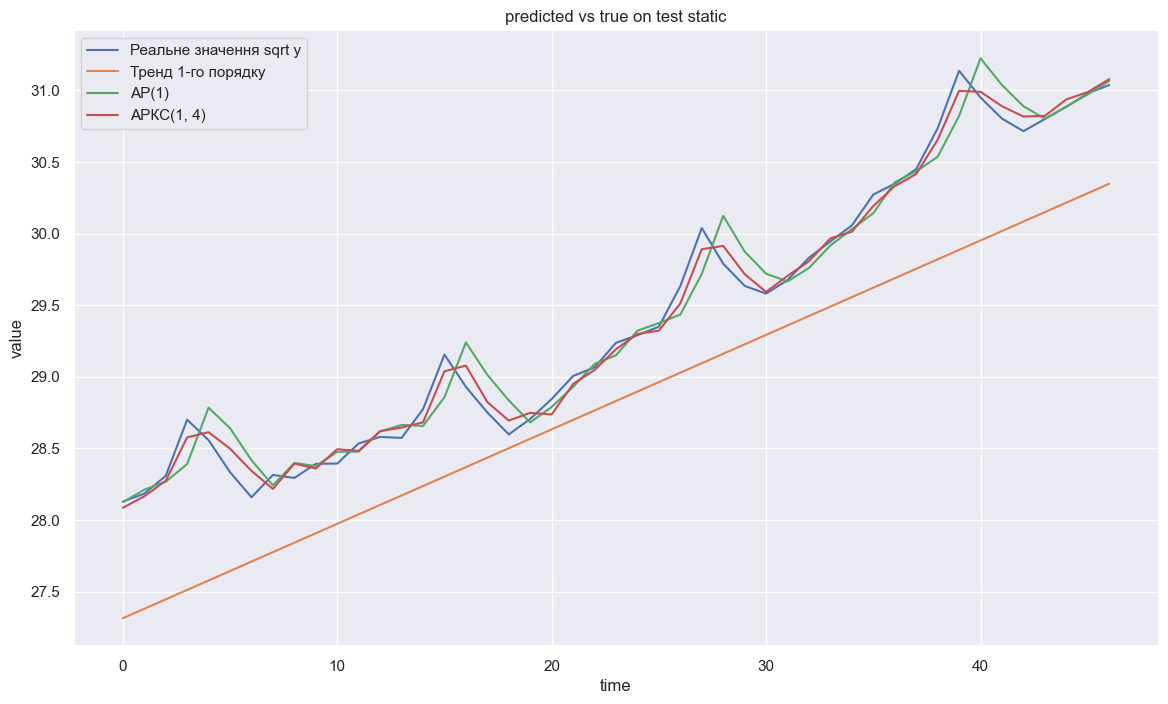

In [94]:
plt.plot(y_revolns_test[2:].values, label='Реальне значення sqrt y')
plt.plot(trend_pred[2:], label='Тренд 1-го порядку')
plt.plot(ar_pred[2:], label='АР(1)')
plt.plot(arma_pred, label='АРКС(1, 4)')
plt.xlabel('time')
plt.ylabel('value')
plt.title('predicted vs true on test static')
plt.legend()
plt.show()

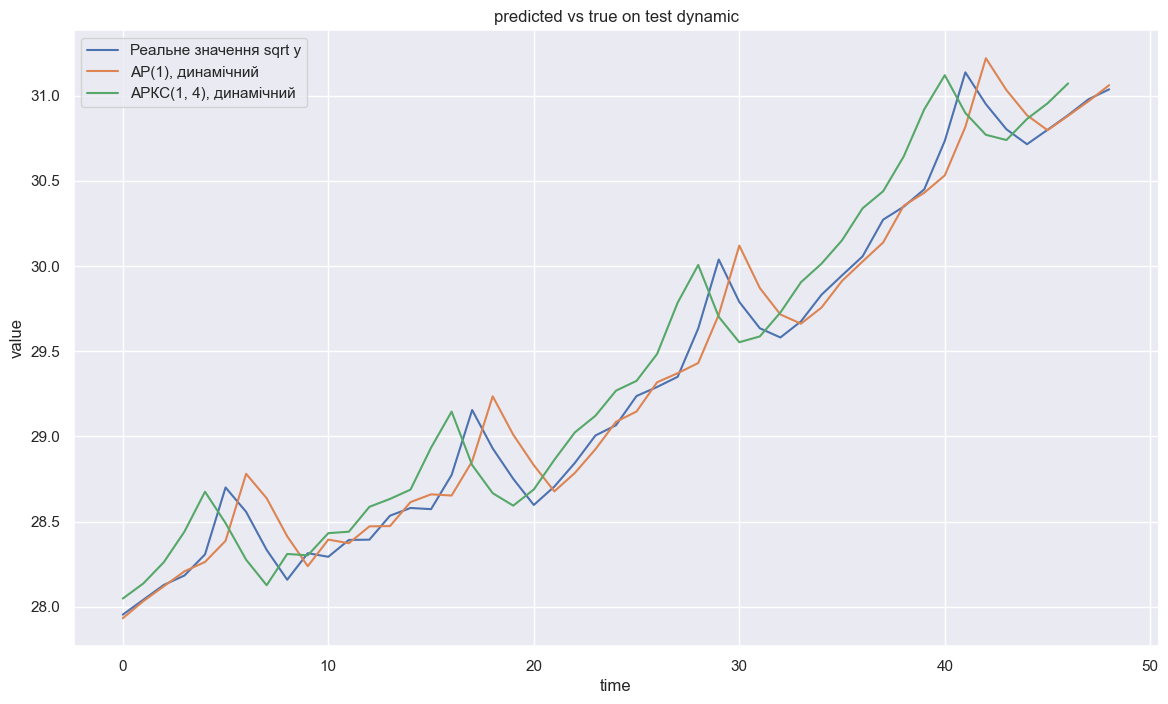

In [95]:
plt.plot(y_revolns_test.values, label='Реальне значення sqrt y')
plt.plot(ar_dyn_pred, label='АР(1), динамічний')
plt.plot(arma_dyn_pred, label='АРКС(1, 4), динамічний')
plt.xlabel('time')
plt.ylabel('value')
plt.title('predicted vs true on test dynamic')
plt.legend()
plt.show()